In [79]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
path="/content/drive/MyDrive/Research/SDC/dataset_4/m_100_size_2000/run_3"

In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
from matplotlib.colors import ListedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [82]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [83]:
x = np.zeros((5000,2))

In [84]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

In [85]:
x[idx[0]][0], x[idx[2]][5] 

(array([4.04729858, 6.43185741]), array([4.46762703, 4.2460364 ]))

In [86]:
print(x.shape,y.shape)

(5000, 2) (5000,)


In [87]:
idx= []
for i in range(10):
  idx.append(y==i)

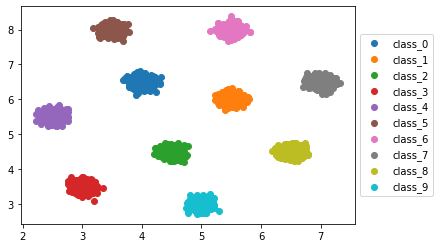

In [88]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [89]:
x = (x -  np.mean(x,axis=0,keepdims=True) ) / np.std(x,axis=0,keepdims=True) 


In [90]:
np.mean(x,axis=0,keepdims=True)

array([[ 4.09857703e-15, -3.00406366e-15]])

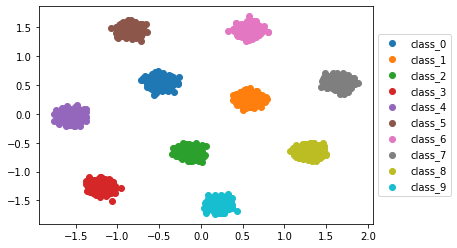

In [91]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [92]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [93]:
desired_num = 3000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,100)
    a = []
    for i in range(100):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(100,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████| 3000/3000 [00:25<00:00, 116.30it/s]


In [94]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [95]:
len(mosaic_list_of_images), mosaic_list_of_images[0],mosaic_list_of_images[0].shape

(3000, array([[ 1.47567327e+00, -6.54288463e-01],
        [ 5.70309537e-01,  1.40548543e+00],
        [ 6.45138085e-01,  1.45552171e+00],
        [-1.49276692e+00, -1.19351958e-01],
        [ 1.29302537e+00, -6.59632751e-01],
        [ 1.69530635e+00,  5.77825956e-01],
        [ 2.33298162e-01, -1.60818073e+00],
        [-1.19634229e+00, -1.30879595e+00],
        [-8.94887062e-01,  1.45514933e+00],
        [ 2.31230274e-01, -1.53243055e+00],
        [ 1.60485457e-01, -1.54922073e+00],
        [-1.58705852e+00, -1.43409509e-02],
        [ 6.43994604e-01,  1.37759531e+00],
        [ 5.67602372e-01,  1.52378643e+00],
        [ 2.19141185e-01, -1.59850438e+00],
        [-1.13305281e+00, -1.34940200e+00],
        [-1.32318630e+00, -1.25935820e+00],
        [ 6.10206335e-01,  1.48882458e+00],
        [ 6.56593191e-01,  1.48538108e+00],
        [ 1.42863187e-01, -1.46428492e+00],
        [-1.25305585e+00, -1.31546647e+00],
        [-1.51580467e+00, -8.43213567e-02],
        [-1.19906115e+00, 

In [96]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [97]:
batch = 100
msd1 = MosaicDataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000] , fore_idx[0:2000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [98]:
data,_,_=iter(train_loader).next()

In [99]:
data.shape

torch.Size([100, 100, 2])

In [100]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[2000:], mosaic_label[2000:] , fore_idx[2000:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [101]:
class Focus(nn.Module):
    def __init__(self):
        super(Focus, self).__init__()
        self.fc1 = nn.Linear(2,50, bias=False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(50, 1, bias=False)
        torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self,z):
        #print("data",z)
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)
        
  
        alpha = F.softmax(alp1,dim=1)
        y = torch.sum(alpha*ft1,dim=1)
        #print(alpha.shape,y.shape)
        alpha =alpha[:,:,0]

        return alpha,y   # return  alpha values,attended data
  
    
    def helper(self, x):
      x1 = x
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x,x1

In [102]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)

  def forward(self, x):
    #print(x.shape)
    #x = x.view(-1, 1)
    #print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [103]:
def plot_attended_data(trainloader,fnet,cnet,nepoch=0):
  attended_data = []
  mlabels = []
  

  with torch.no_grad():
    for data in train_loader:
      inputs, labels , fore_idx = data
      inputs = inputs.double()
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      alphas, avg_data = fnet(inputs)

      mlabels.append(labels.cpu().numpy())
      attended_data.append(avg_data.cpu().numpy())
  
  mlabels = np.concatenate(mlabels,axis=0)
  attended_data = np.concatenate(attended_data,axis=0)

  plt.figure(figsize=(6,8))
  colours = ListedColormap(['r','b',"g"])
  scatter = plt.scatter(attended_data[:,0] ,attended_data[:,1],c=mlabels,cmap=colours,alpha=0.8)
  plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])
  plt.title("Attended Data "+str(nepoch))


  X,Y = torch.meshgrid(torch.linspace(-1.5,4.5,100), torch.linspace(-1,6,100))
  n=X.shape[0]*X.shape[1]
  data = torch.zeros((n,2)).double()
  data[:,0]=X.reshape((-1,))
  data[:,1]=Y.reshape((-1,))
  data = data.to("cuda")
  with torch.no_grad():
    Z,_ = fnet.helper(data)
  Z = Z.cpu().numpy()
  Z = Z.reshape(X.shape)
  plt.figure(figsize=(6,8))
  cax = plt.contourf(X,Y,Z,)
  plt.colorbar(cax)
  plt.title("Focus Map "+str(nepoch))

  with torch.no_grad():
    Z1 = cnet(data)
  _, Z1 = torch.max(Z1.data, 1)
  Z1 = Z1.cpu().numpy()
  
  Z1 = Z1.reshape(X.shape)


  plt.figure(figsize=(6,8))
  cax = plt.contourf(X,Y,Z1)
  plt.colorbar(cax)
  scatter = plt.scatter(attended_data[:,0] ,attended_data[:,1],c=mlabels,cmap=colours,alpha=0.8)
  plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])
  plt.title("classification map "+str(nepoch))




  

In [104]:
torch.manual_seed(13)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [105]:
torch.manual_seed(13)
classify = Classification().double()
classify = classify.to("cuda")

In [106]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.01 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

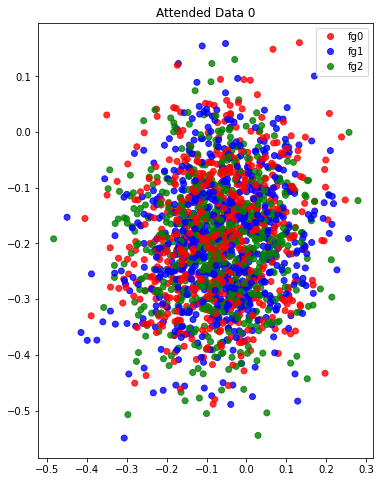

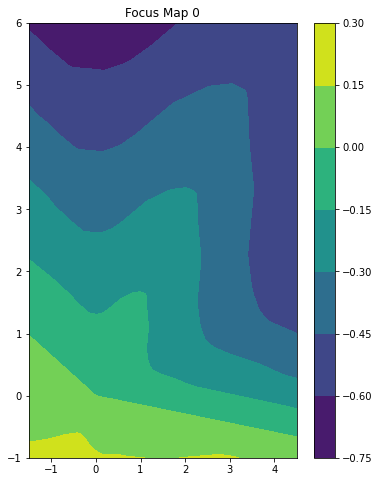

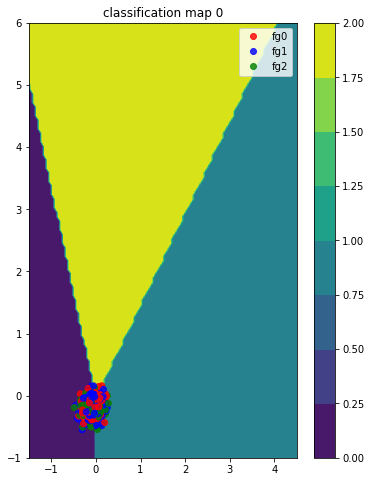

In [107]:
plot_attended_data(train_loader,focus_net,classify,0)

In [108]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [109]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)
    # print(predicted.shape)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      # print(focus, fore_idx[j], predicted[j])
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the train images: 34.200000 %
total correct 684
total train set images 2000
focus_true_pred_true 0 =============> FTPT : 0.000000 %
focus_false_pred_true 684 =============> FFPT : 34.200000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 1316 =============> FFPF : 65.800000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  2000
2000


In [110]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the test images: 35.600000 %
total correct 356
total train set images 1000
focus_true_pred_true 0 =============> FTPT : 0.000000 %
focus_false_pred_true 356 =============> FFPT : 35.600000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 644 =============> FFPF : 64.400000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000


[1,    20] loss: 1.100
[2,    20] loss: 1.099
[3,    20] loss: 1.099
[4,    20] loss: 1.098
[5,    20] loss: 1.098
[6,    20] loss: 1.098
[7,    20] loss: 1.097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[8,    20] loss: 1.098


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[9,    20] loss: 1.098
[10,    20] loss: 1.098
[11,    20] loss: 1.097
[12,    20] loss: 1.097
[13,    20] loss: 1.097
[14,    20] loss: 1.096
[15,    20] loss: 1.095
[16,    20] loss: 1.096
[17,    20] loss: 1.094
[18,    20] loss: 1.097
[19,    20] loss: 1.092
[20,    20] loss: 1.091
[21,    20] loss: 1.089
[22,    20] loss: 1.086
[23,    20] loss: 1.069
[24,    20] loss: 0.947
[25,    20] loss: 0.332
[26,    20] loss: 0.150
[27,    20] loss: 0.097
[28,    20] loss: 0.073
[29,    20] loss: 0.059
[30,    20] loss: 0.050
[31,    20] loss: 0.043
[32,    20] loss: 0.038
[33,    20] loss: 0.034
[34,    20] loss: 0.030
[35,    20] loss: 0.028
[36,    20] loss: 0.025
[37,    20] loss: 0.023
[38,    20] loss: 0.021
[39,    20] loss: 0.020
[40,    20] loss: 0.019
[41,    20] loss: 0.017
[42,    20] loss: 0.016
[43,    20] loss: 0.016
[44,    20] loss: 0.015
[45,    20] loss: 0.014
[46,    20] loss: 0.013
[47,    20] loss: 0.013
[48,    20] loss: 0.012
[49,    20] loss: 0.011
[50,    20] loss:

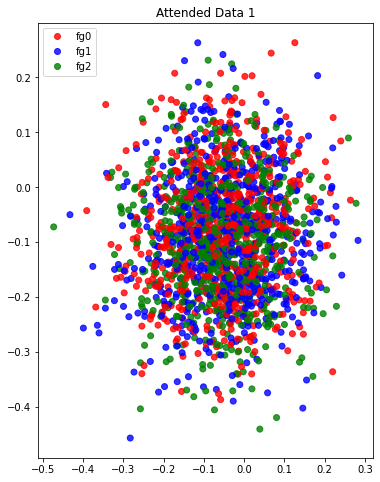

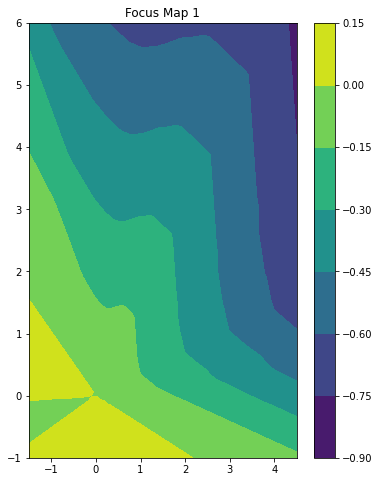

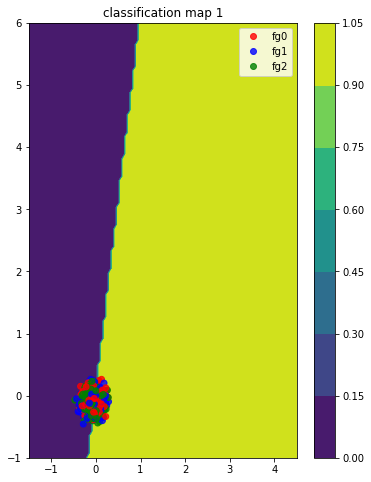

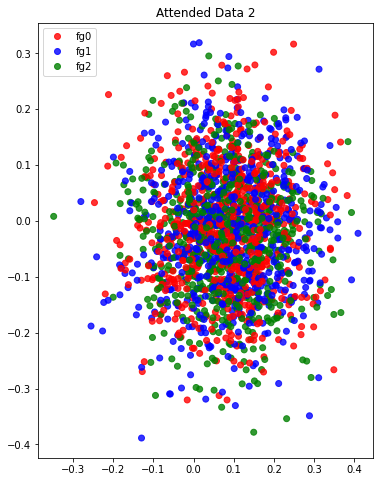

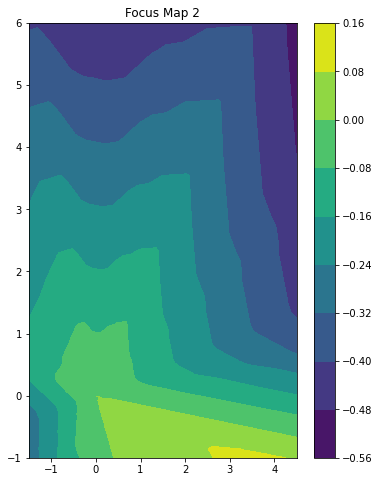

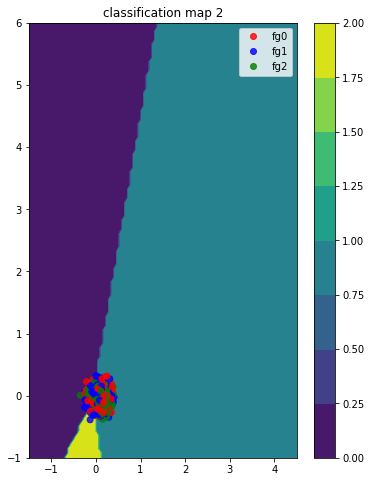

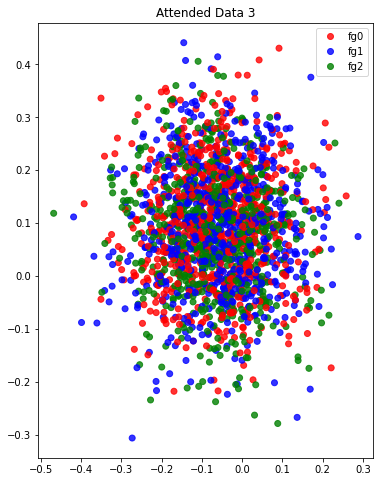

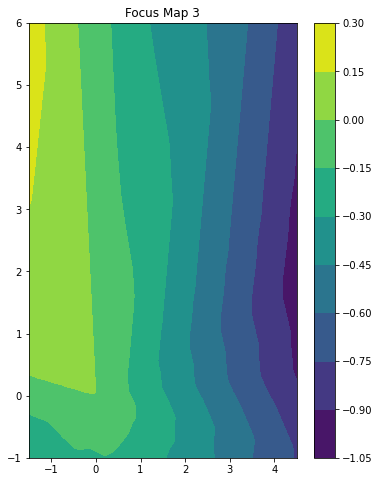

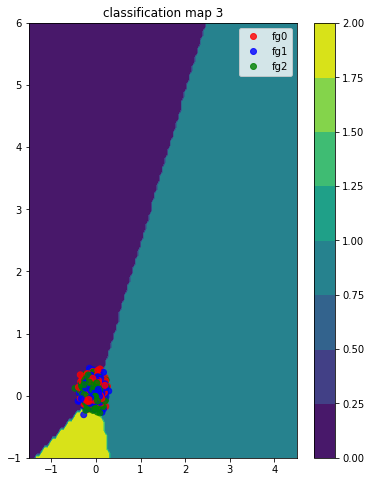

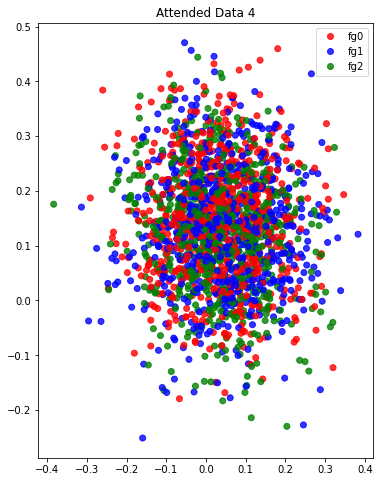

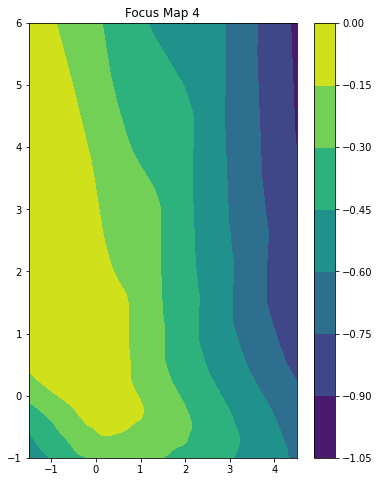

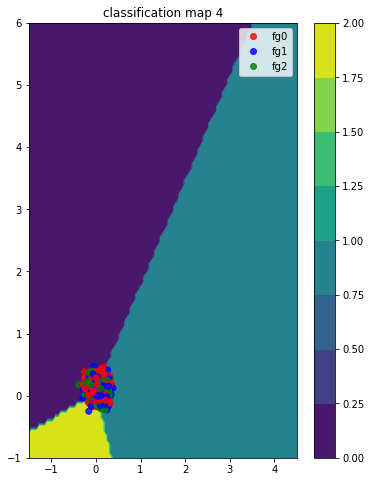

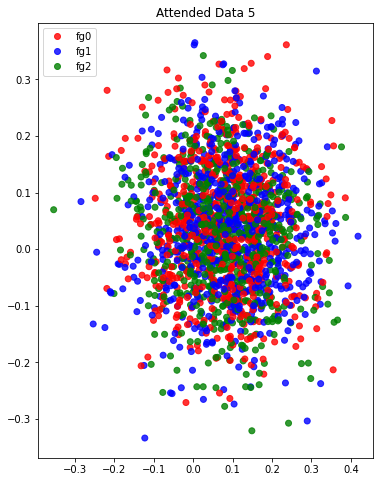

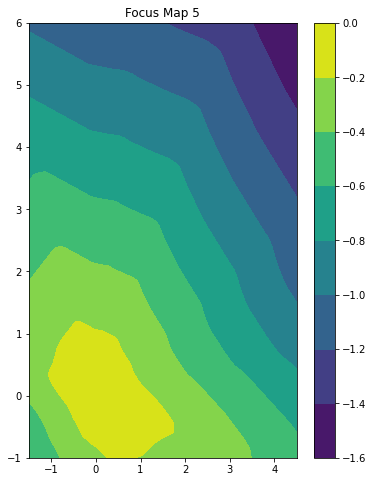

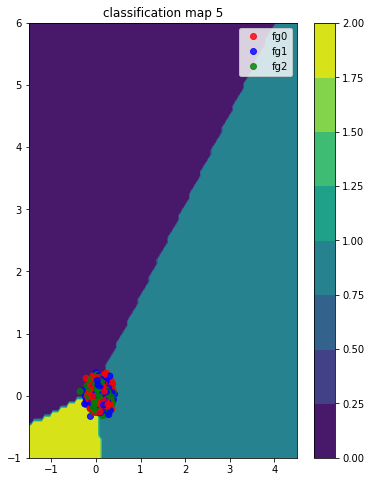

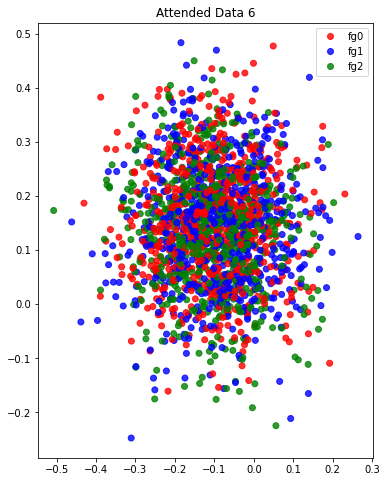

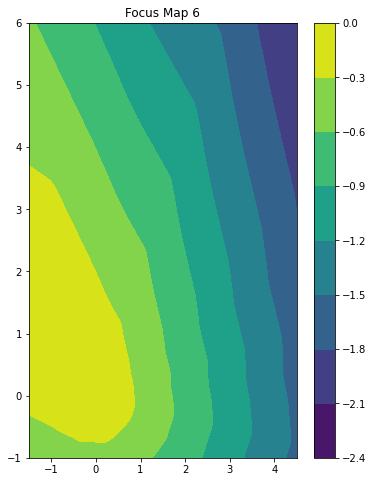

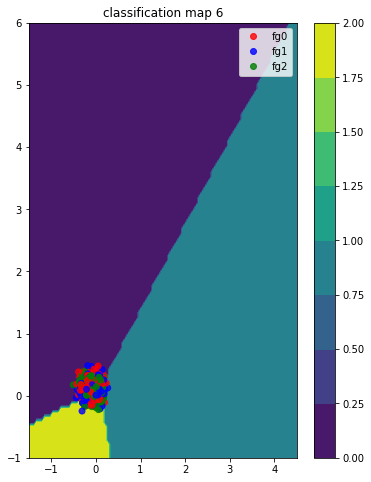

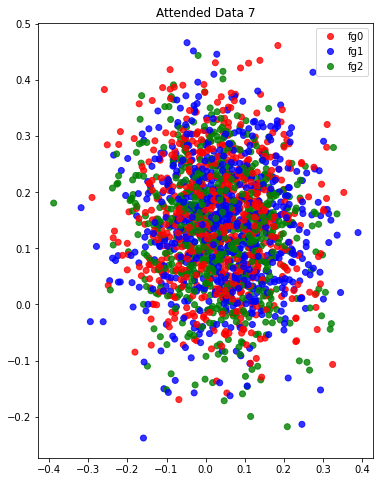

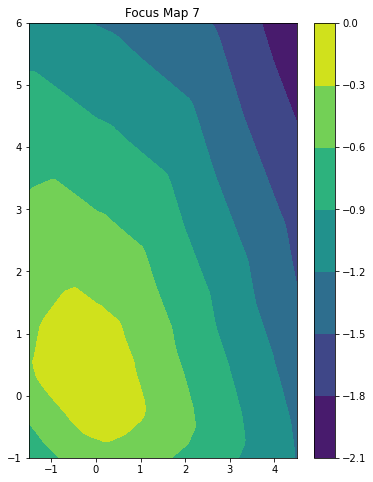

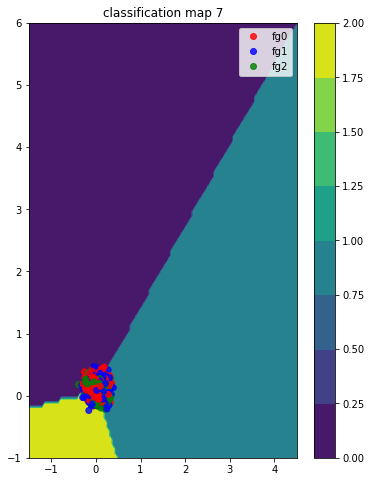

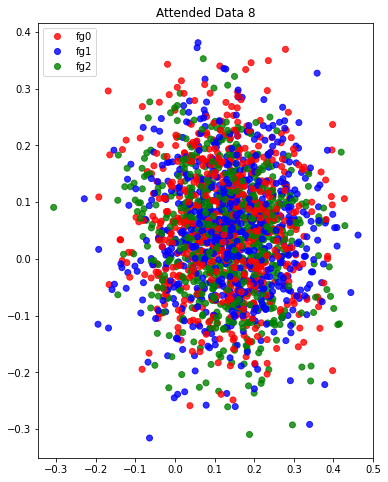

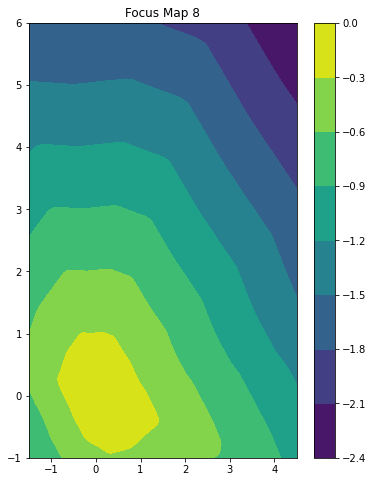

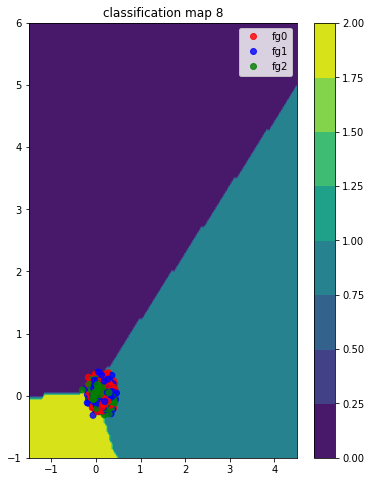

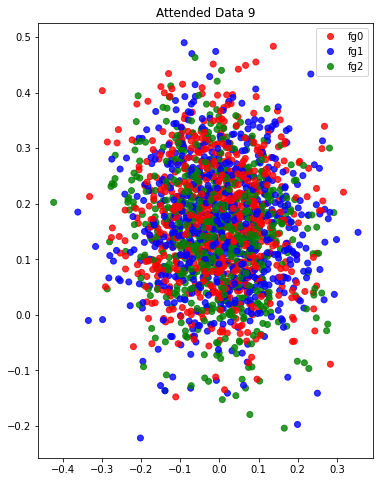

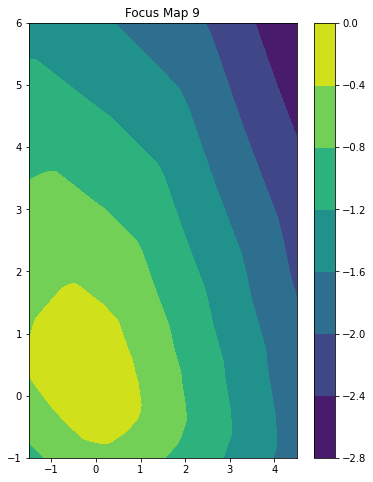

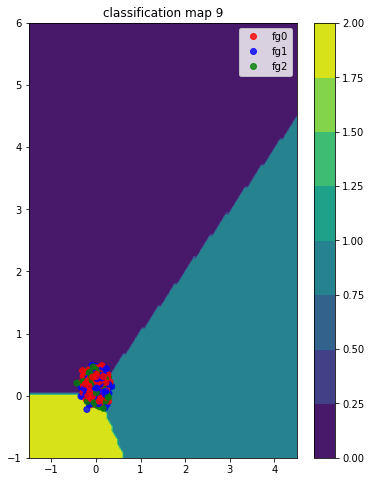

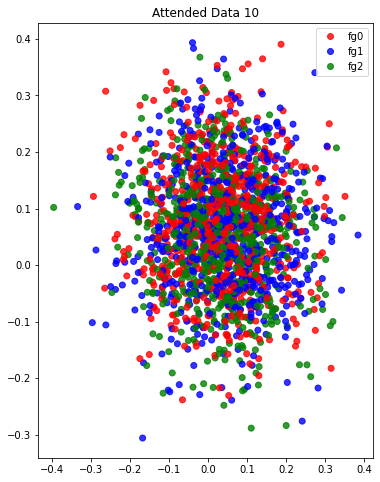

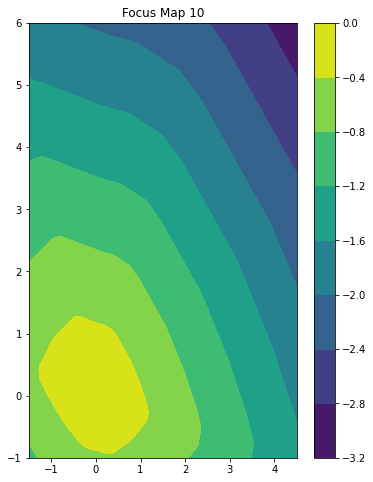

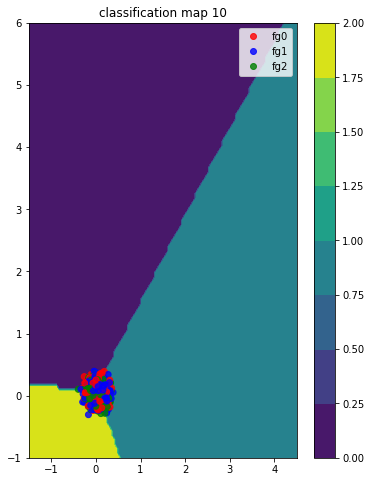

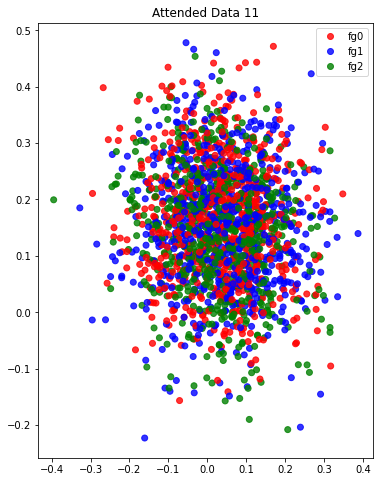

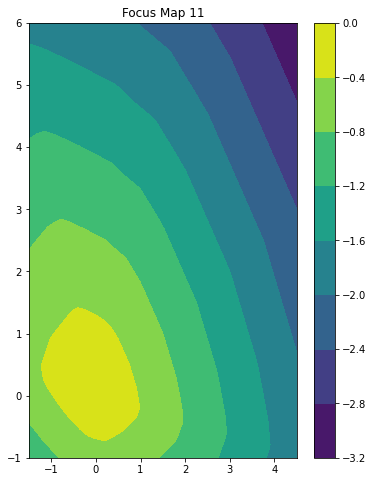

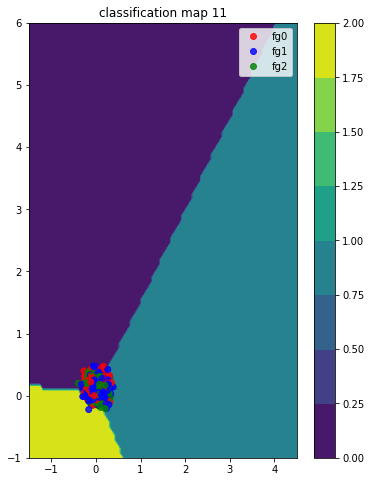

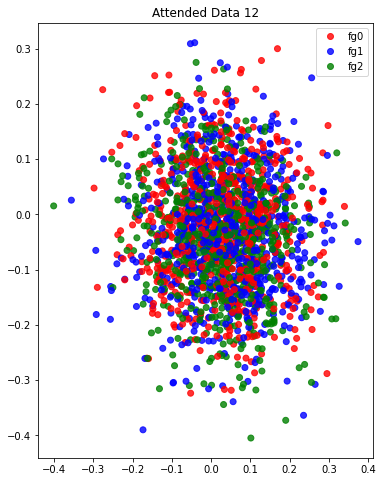

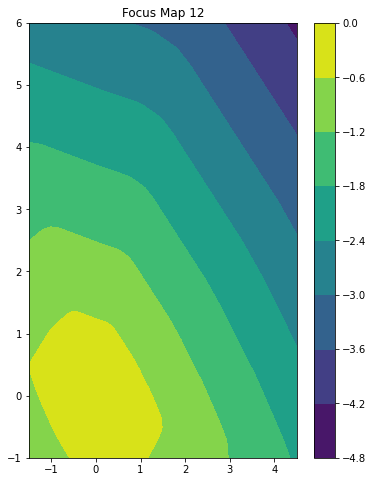

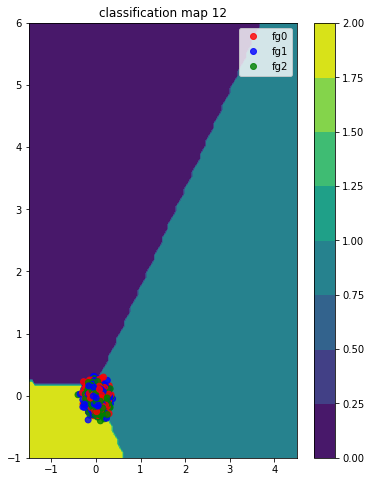

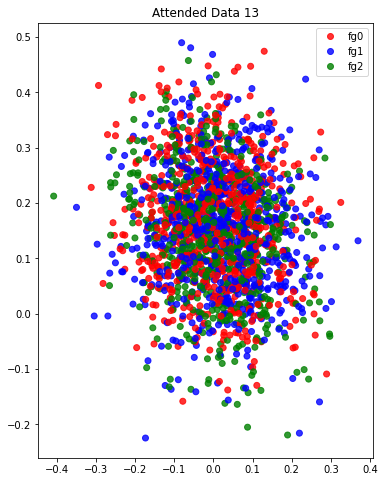

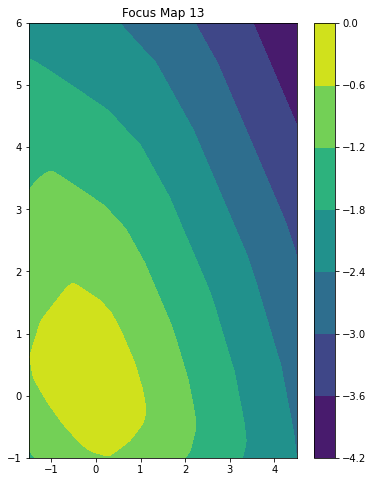

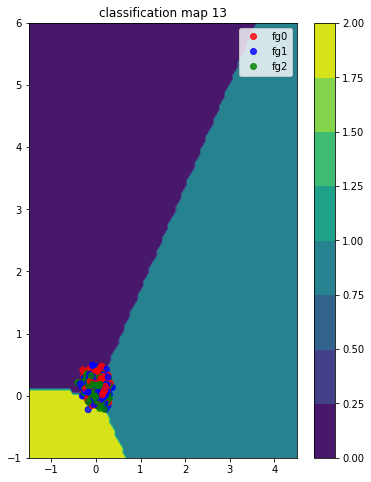

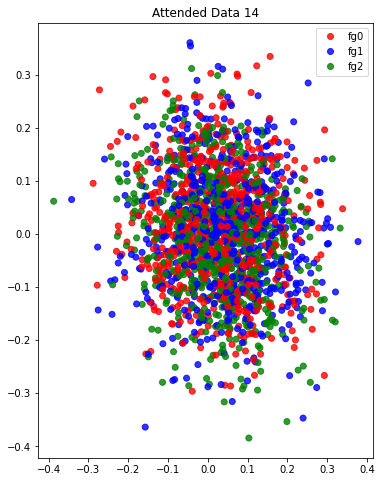

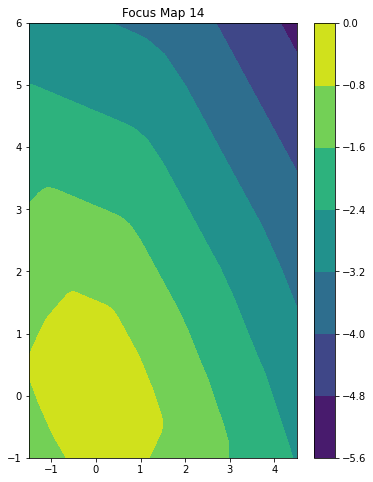

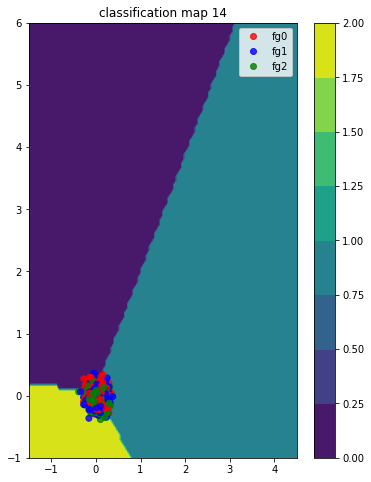

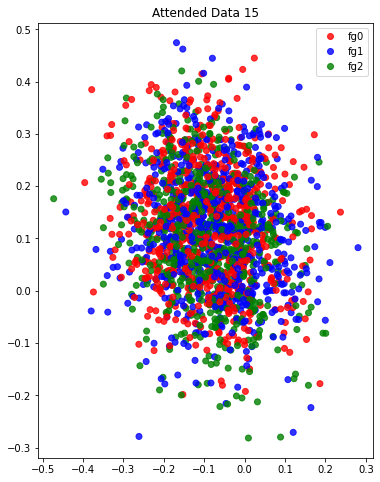

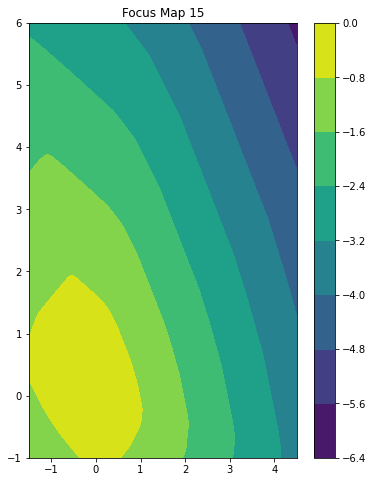

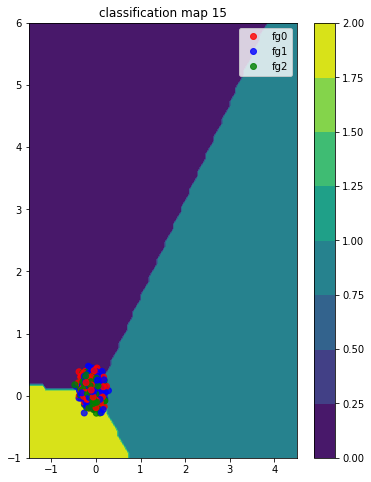

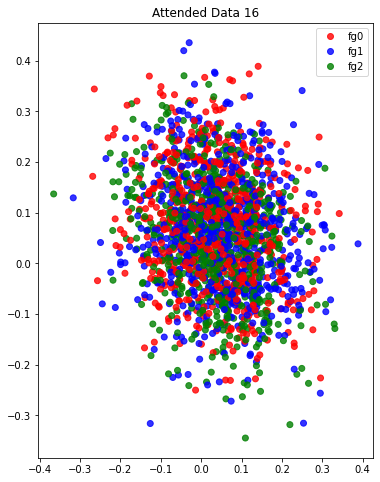

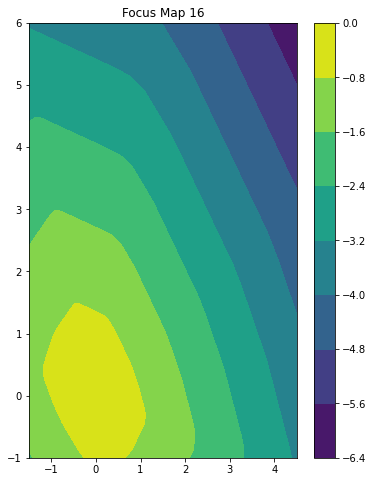

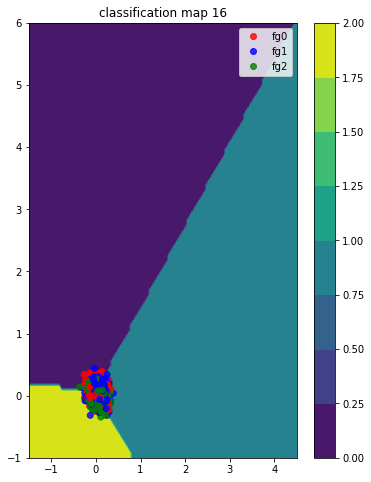

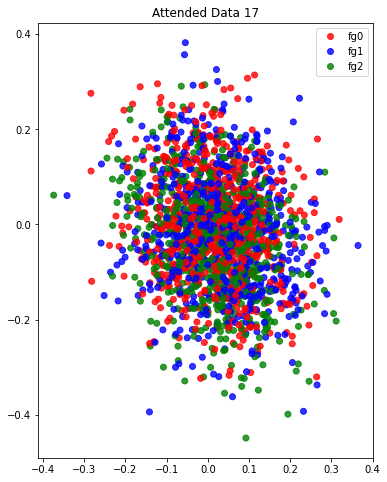

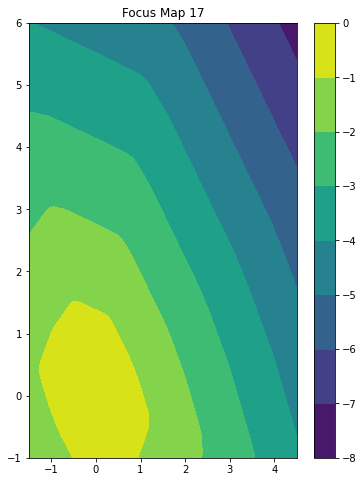

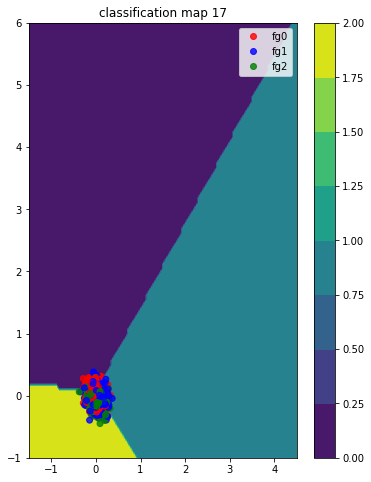

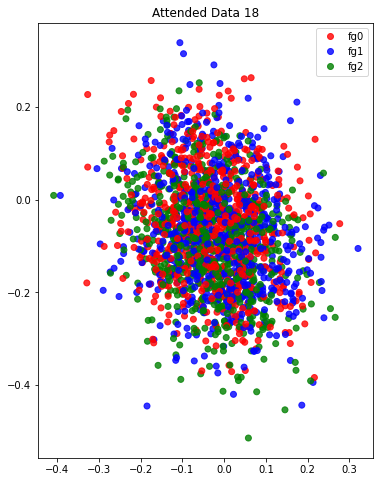

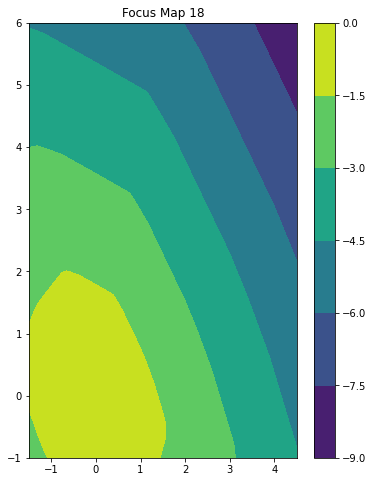

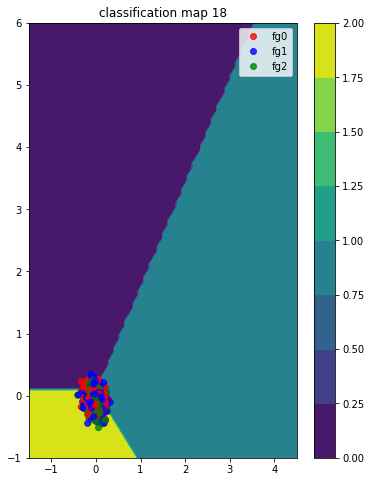

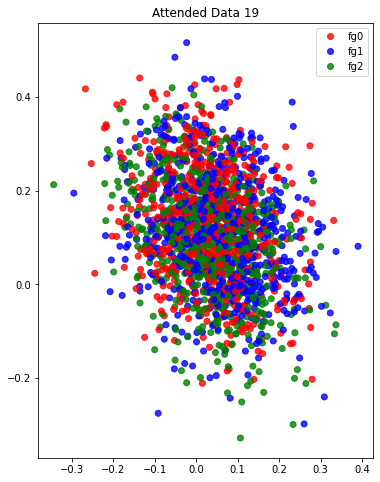

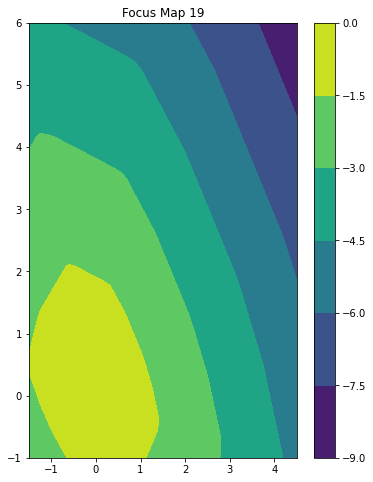

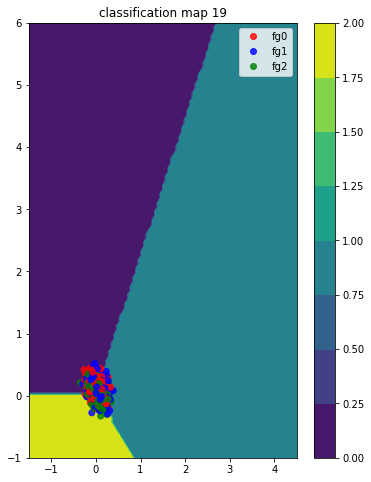

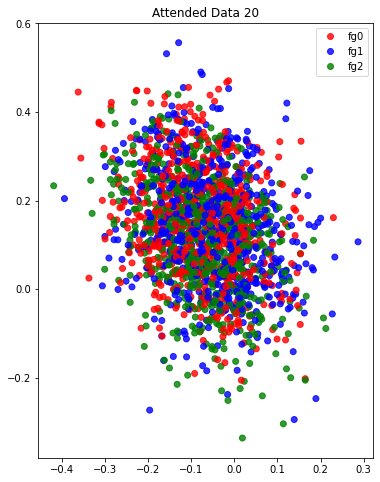

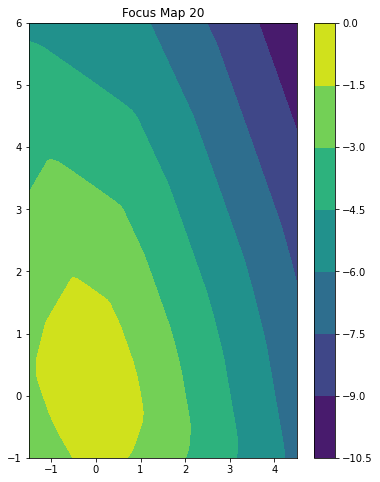

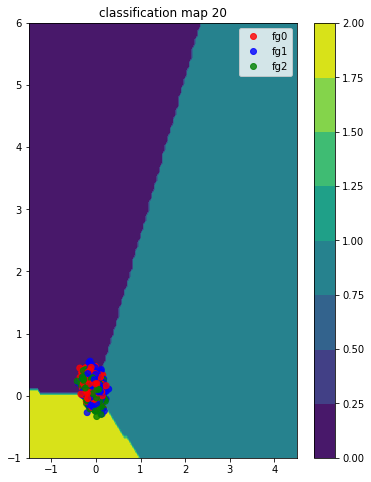

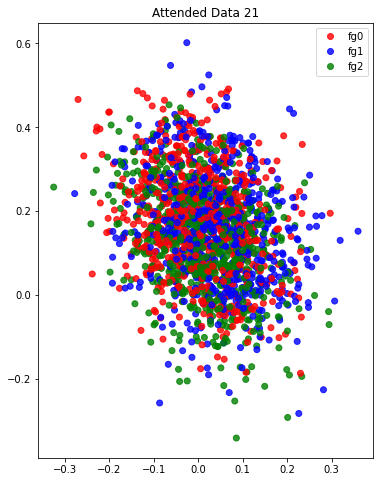

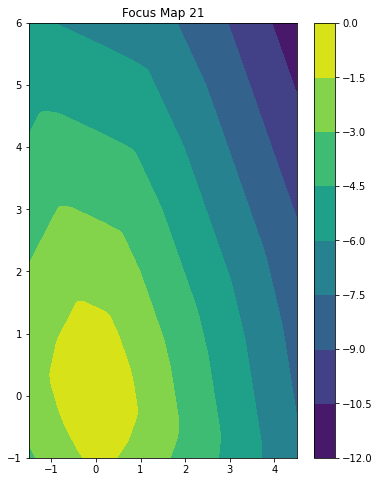

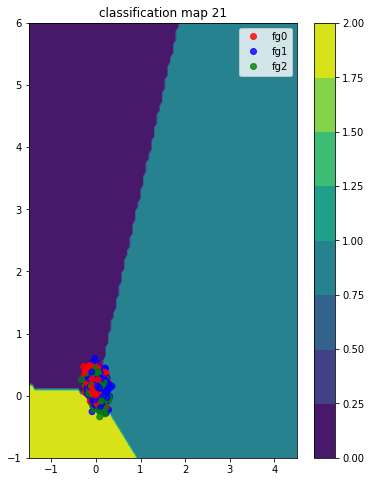

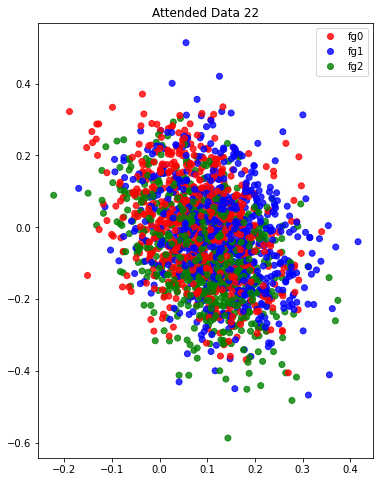

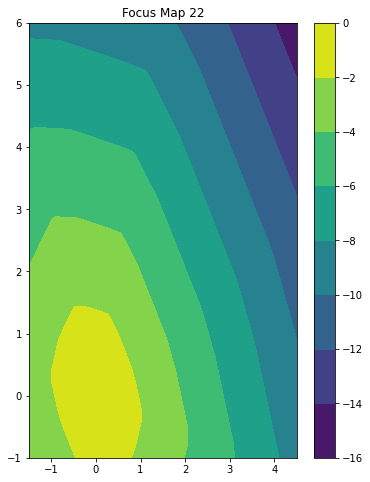

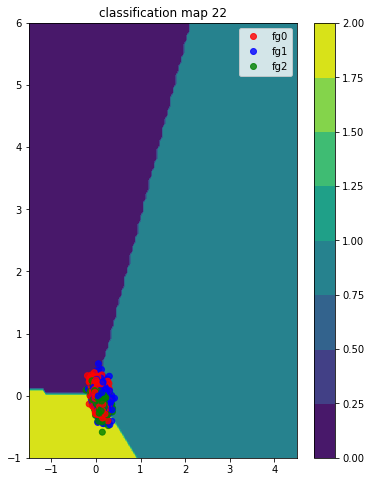

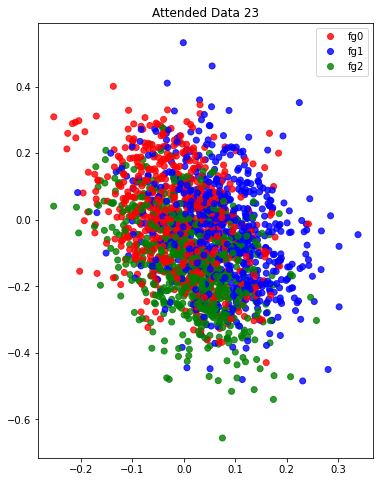

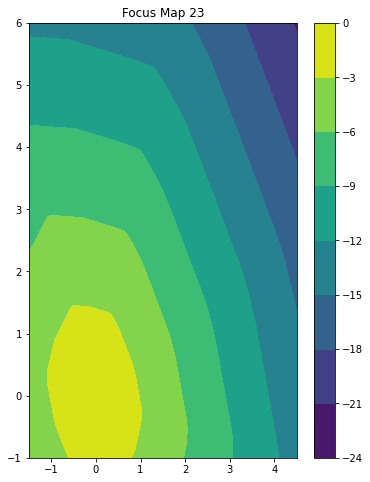

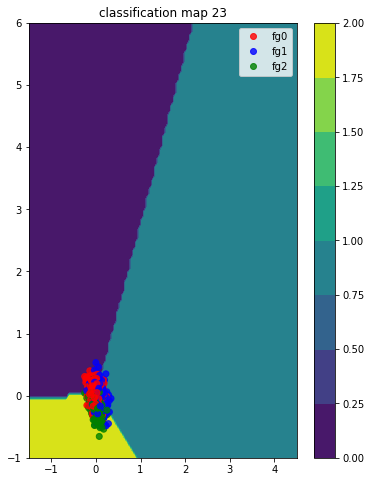

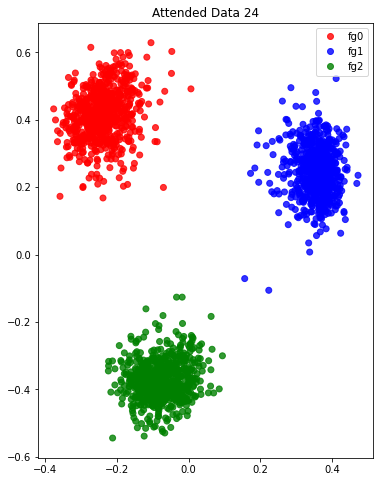

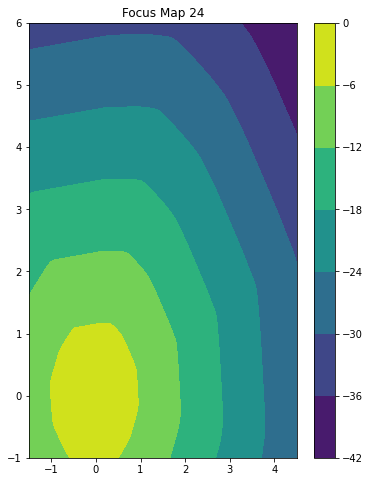

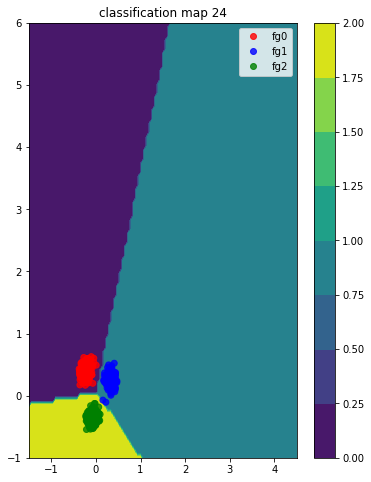

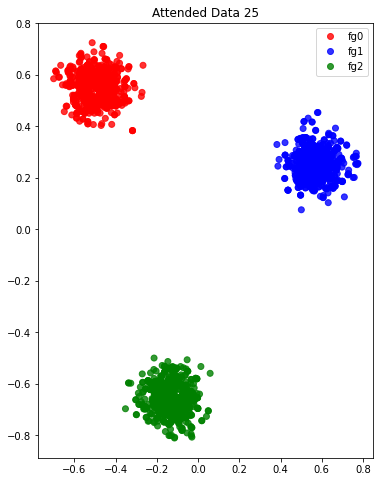

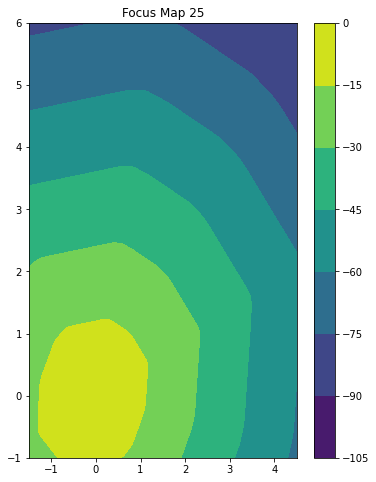

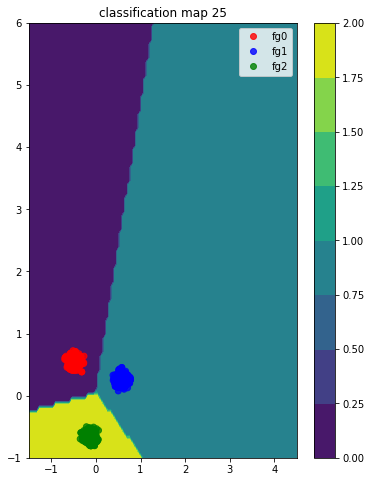

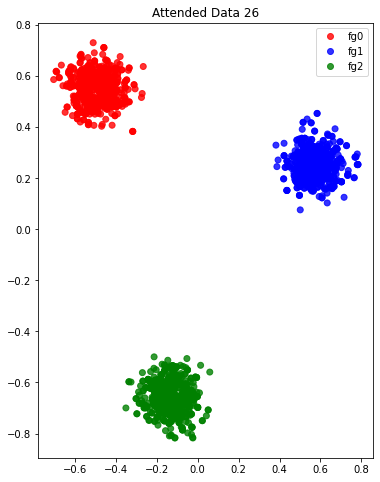

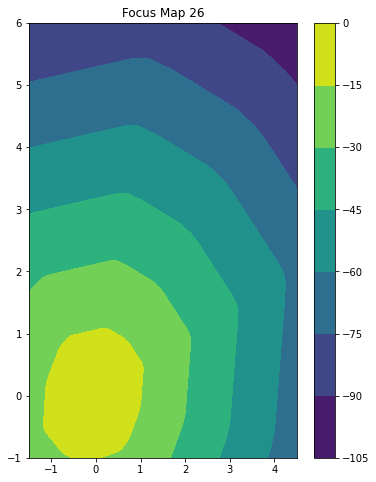

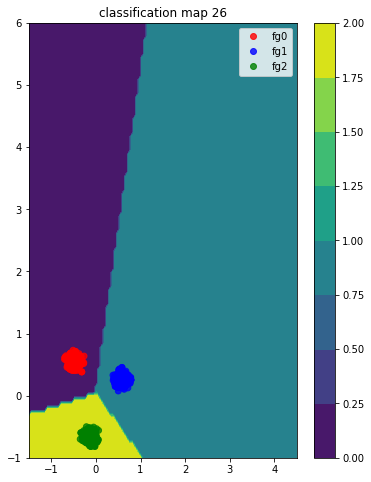

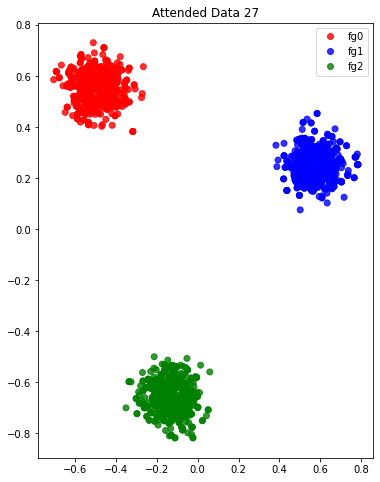

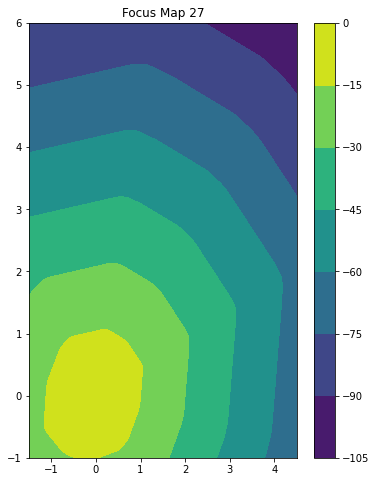

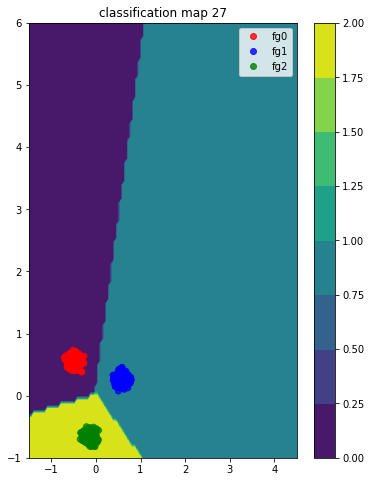

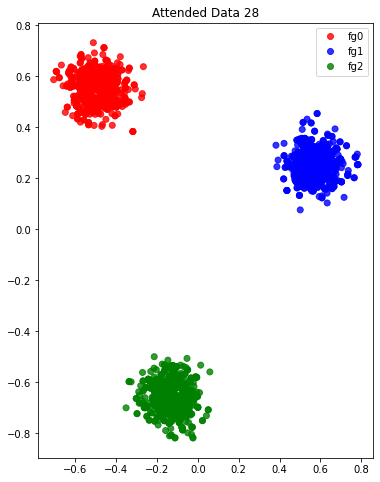

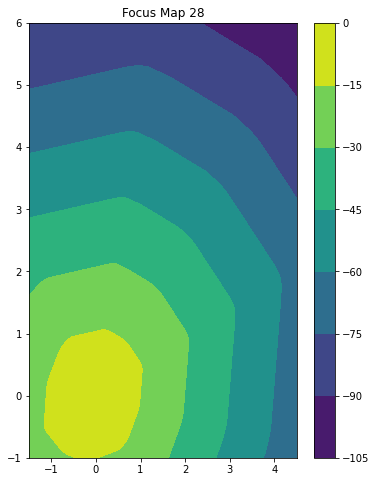

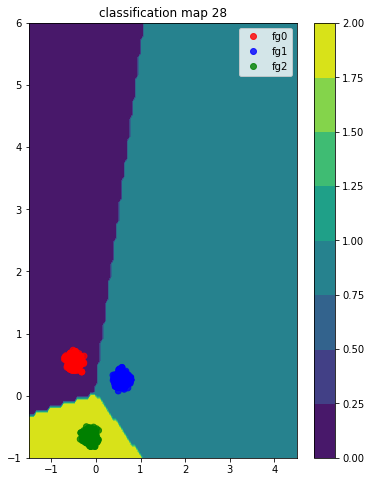

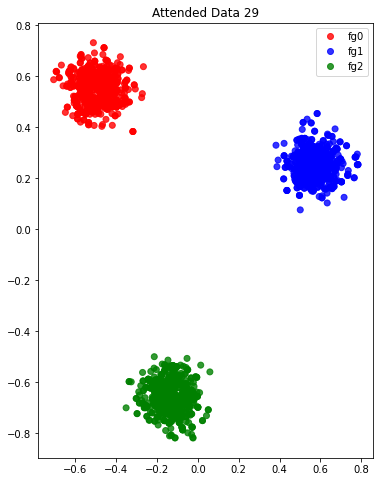

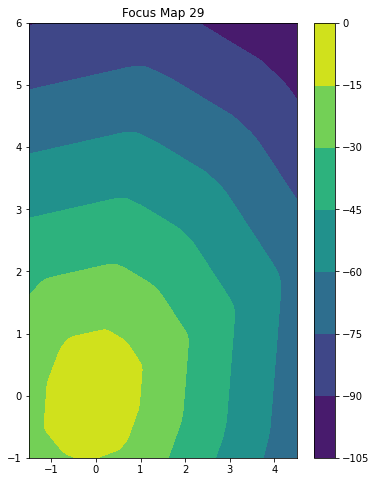

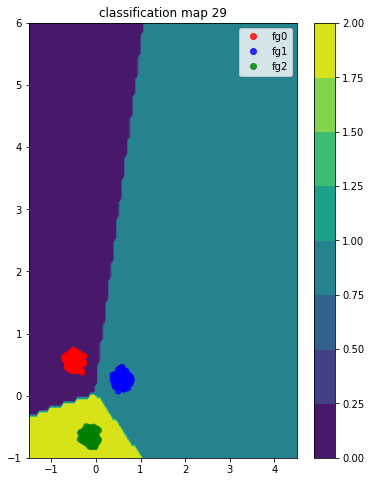

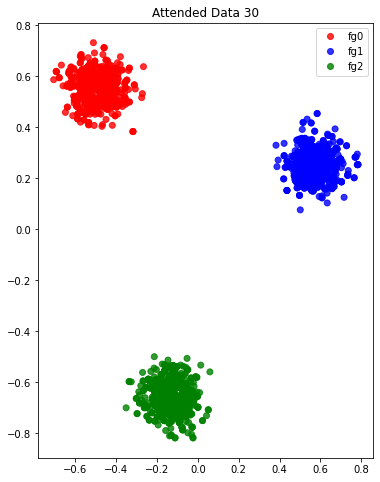

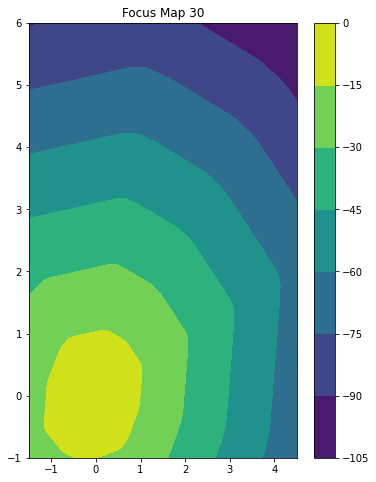

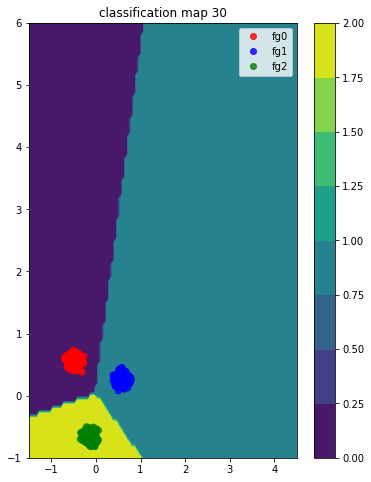

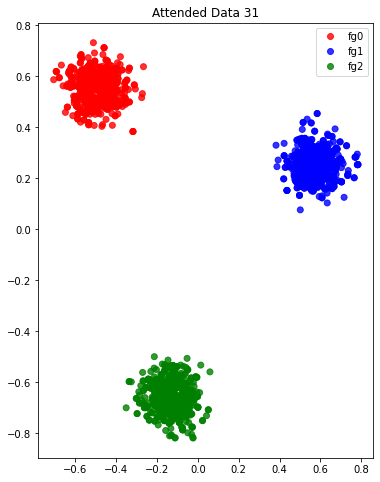

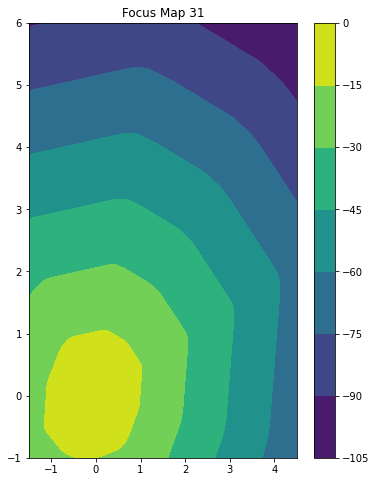

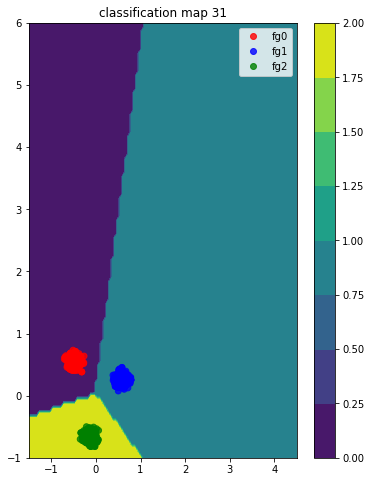

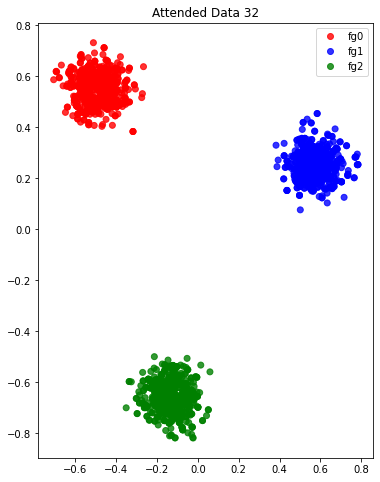

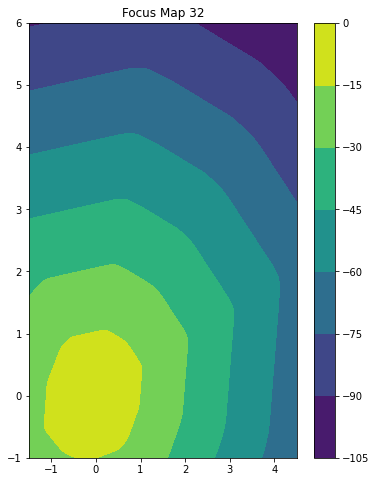

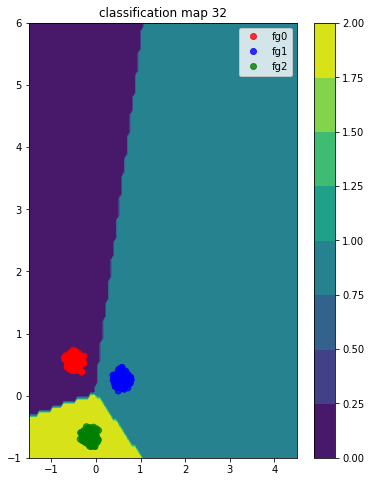

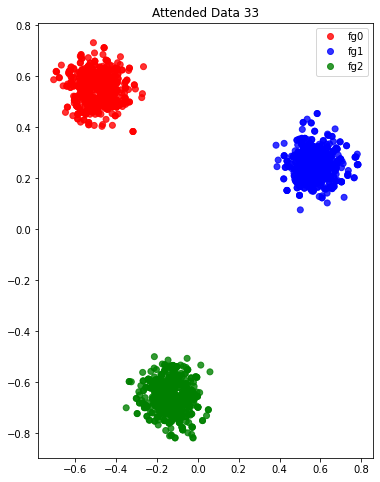

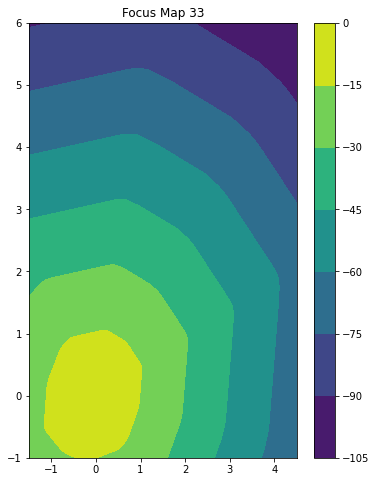

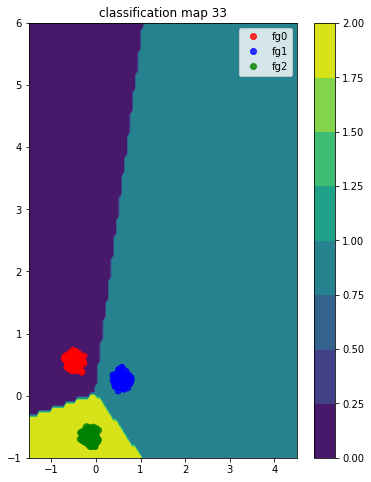

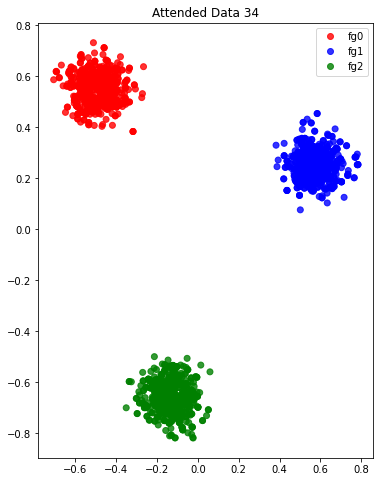

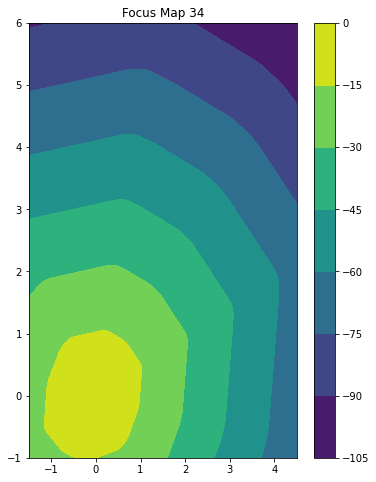

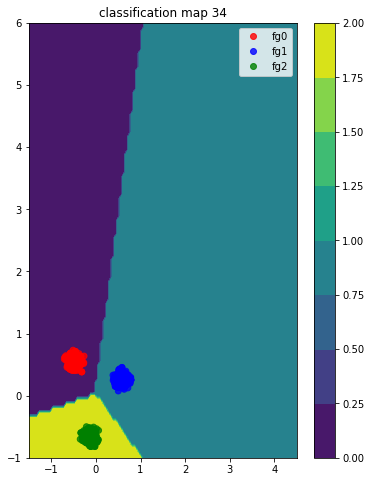

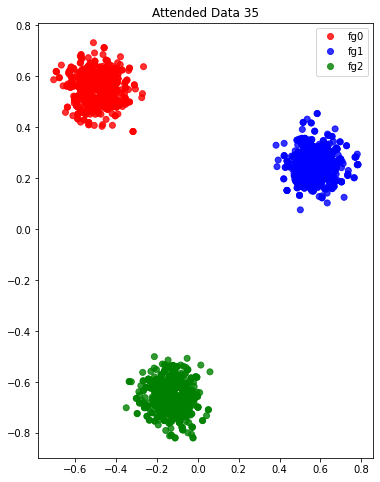

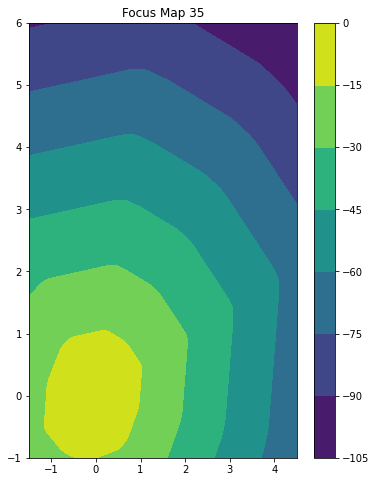

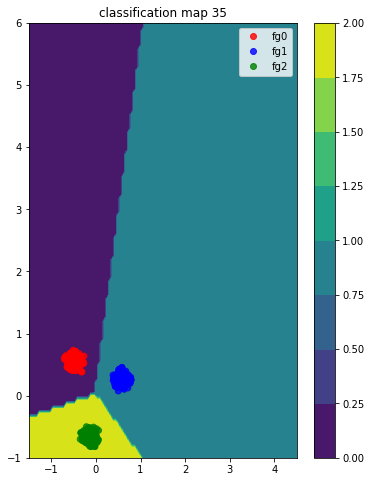

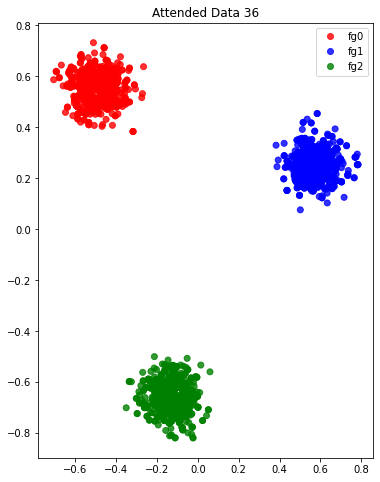

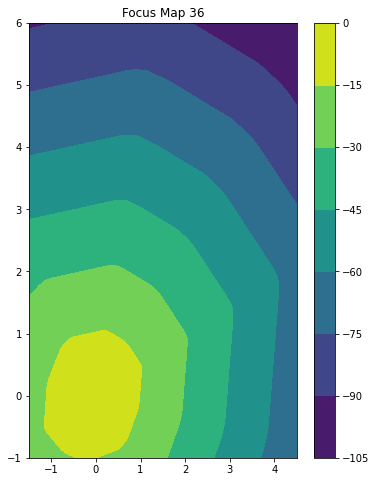

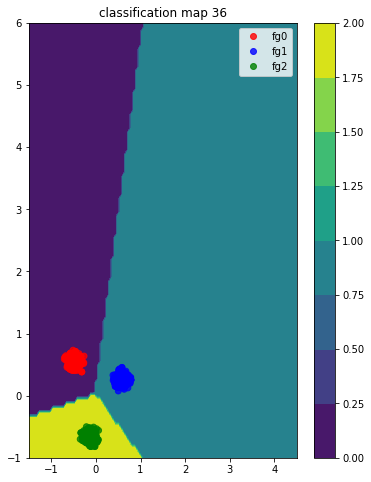

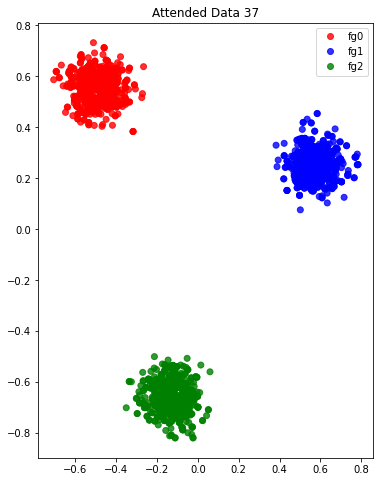

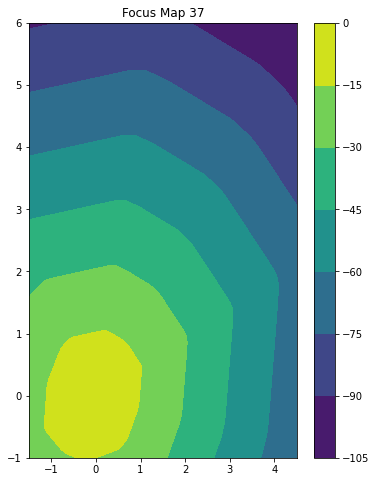

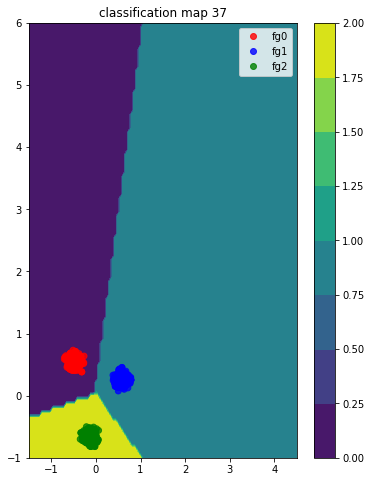

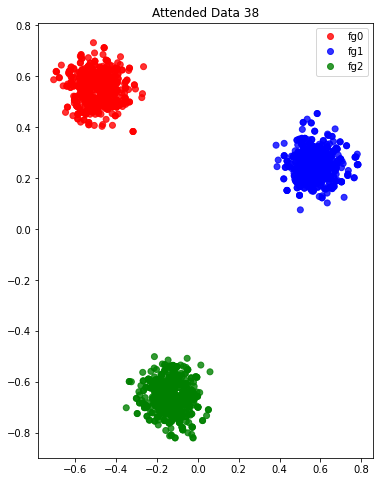

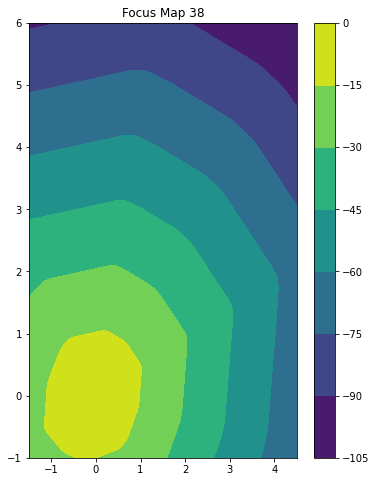

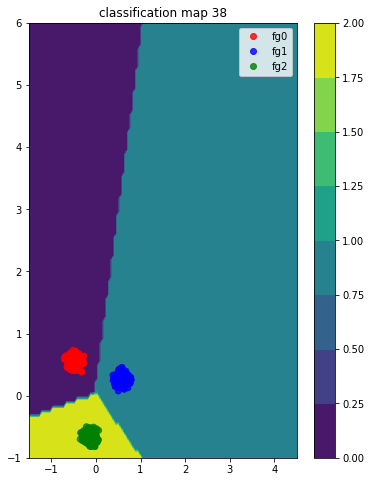

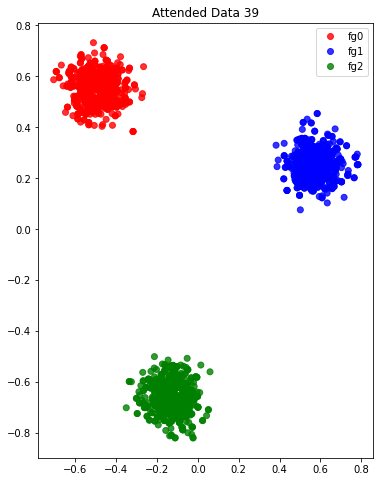

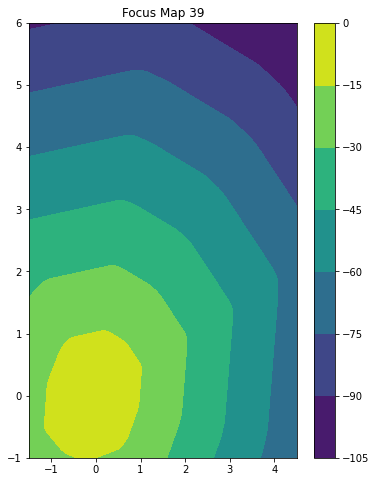

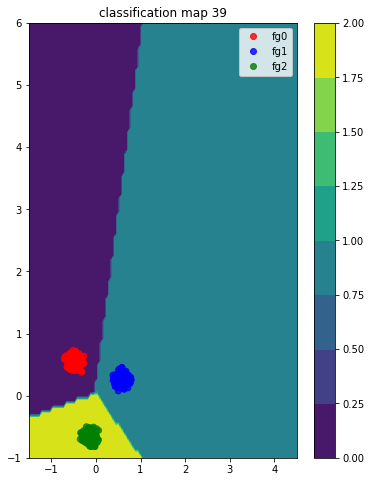

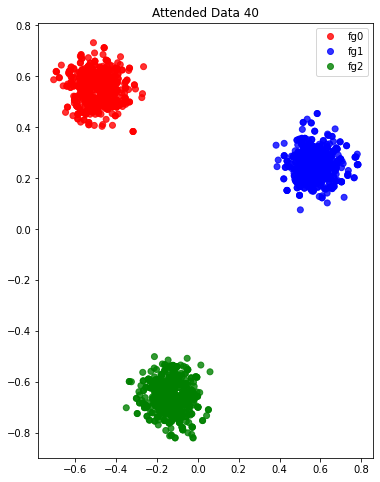

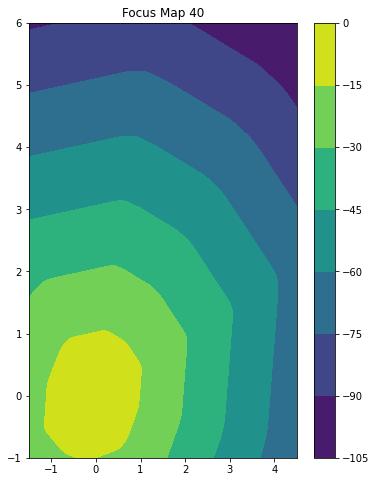

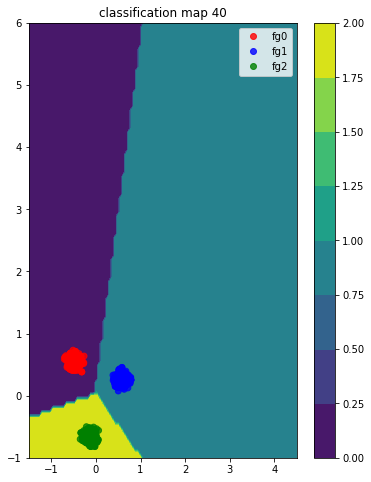

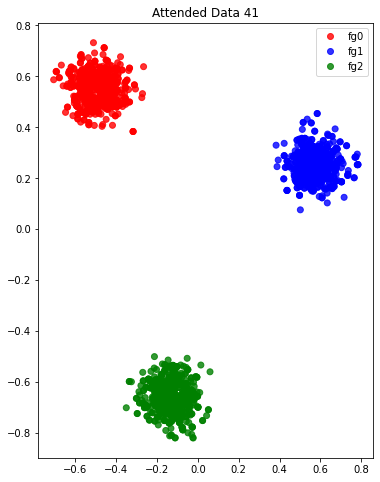

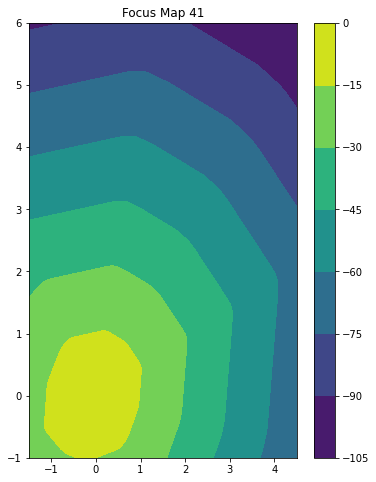

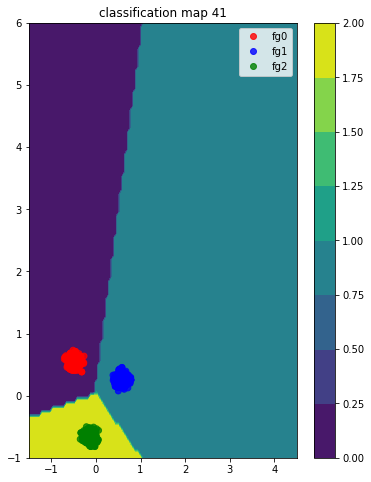

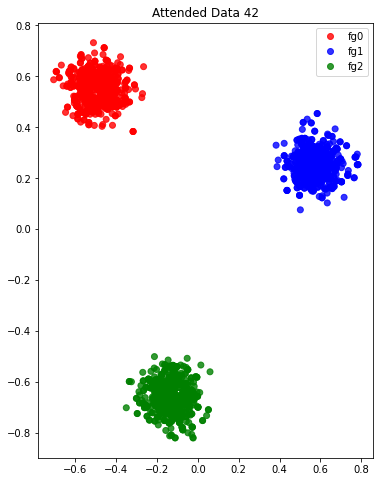

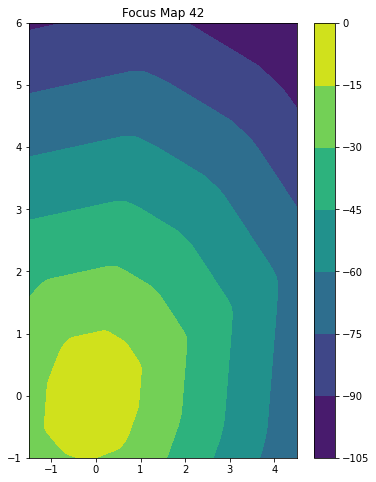

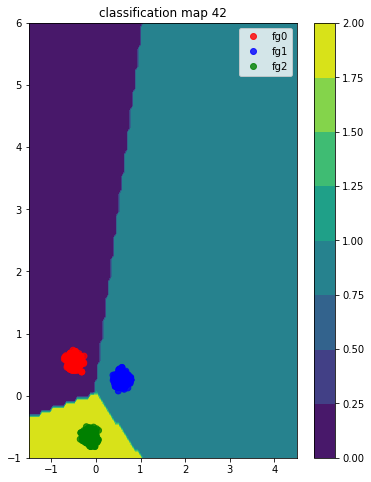

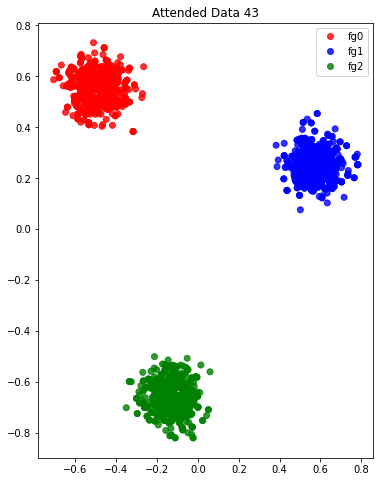

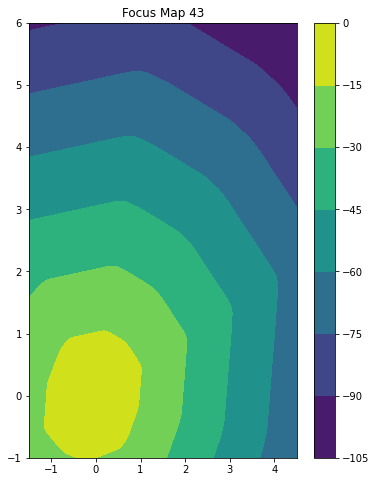

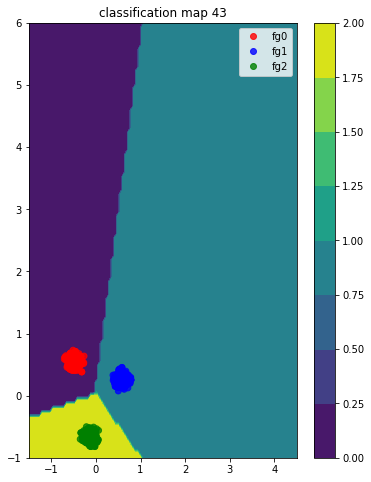

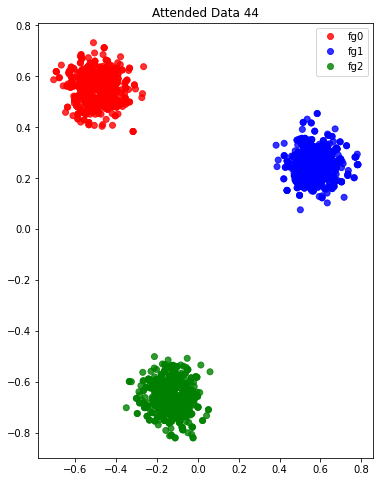

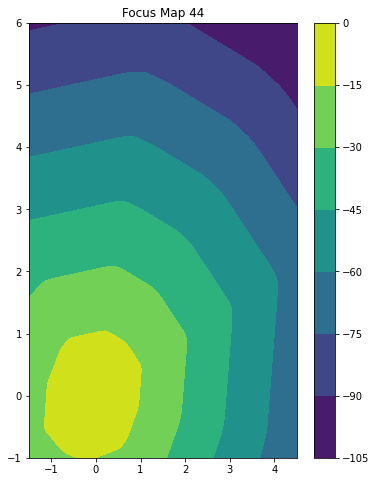

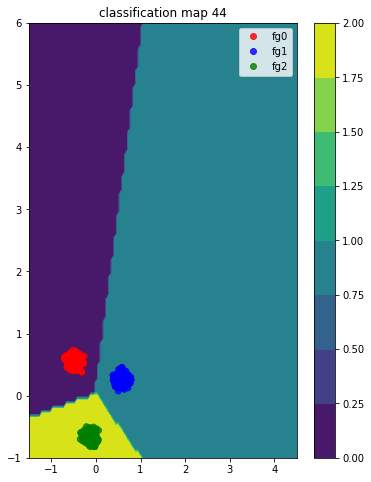

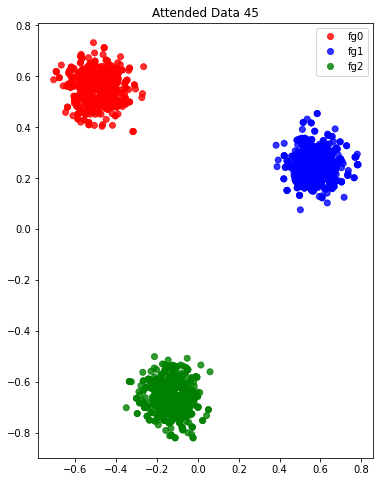

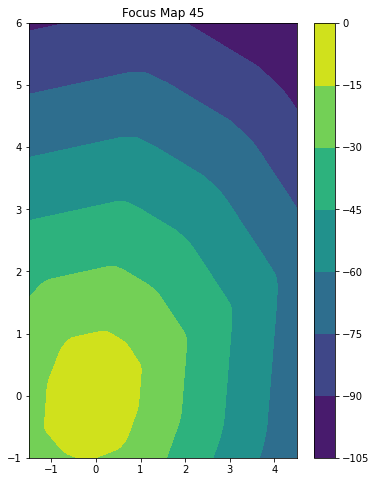

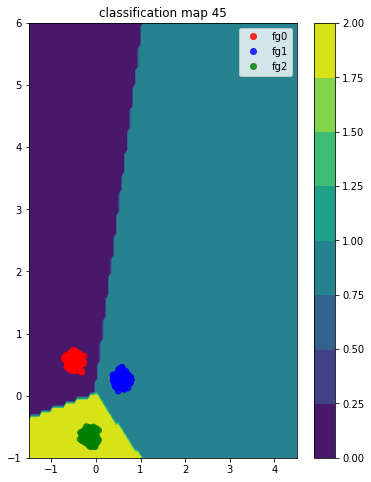

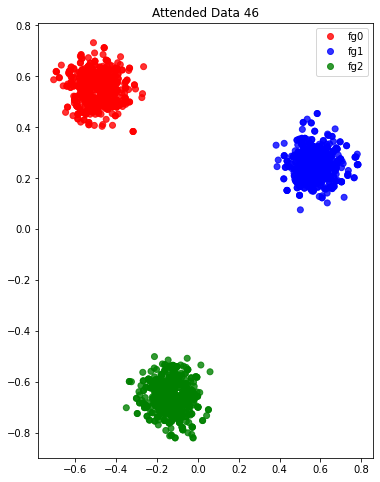

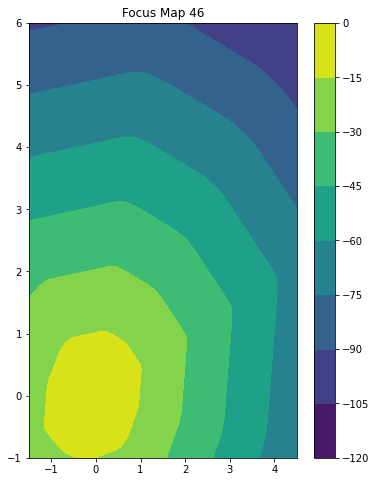

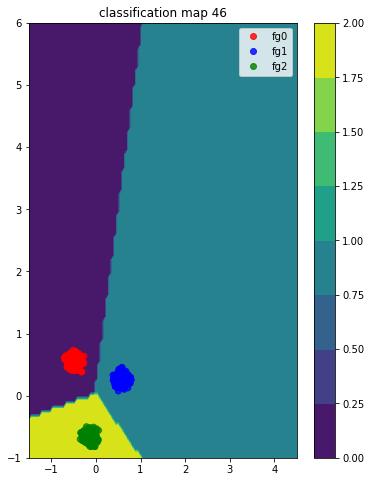

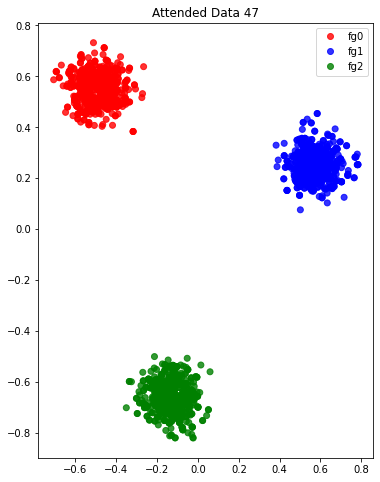

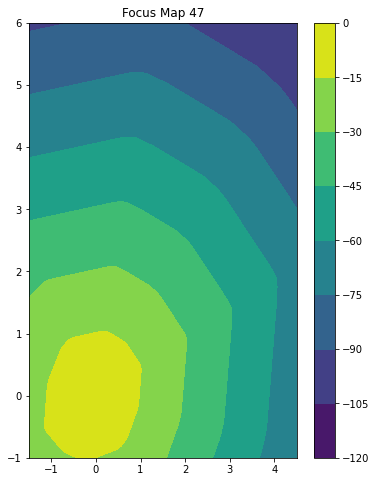

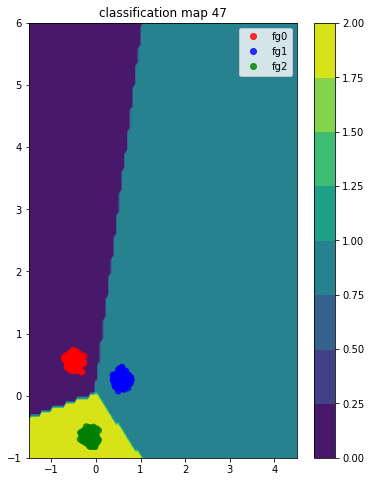

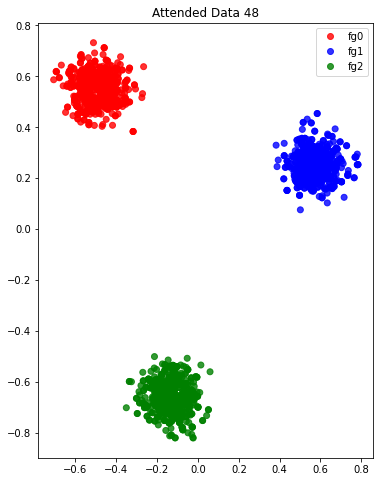

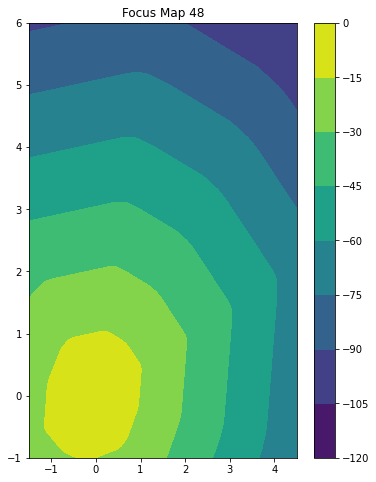

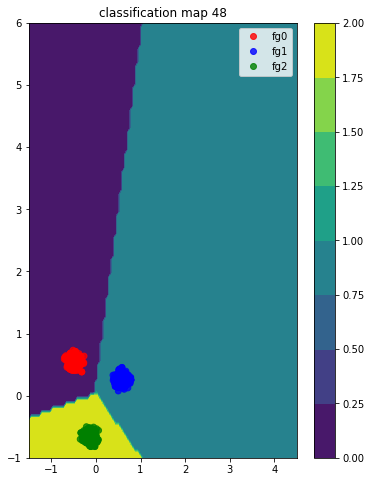

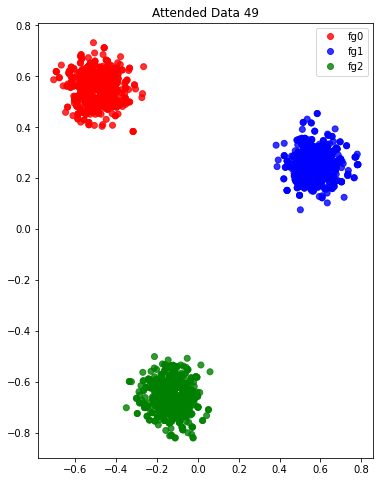

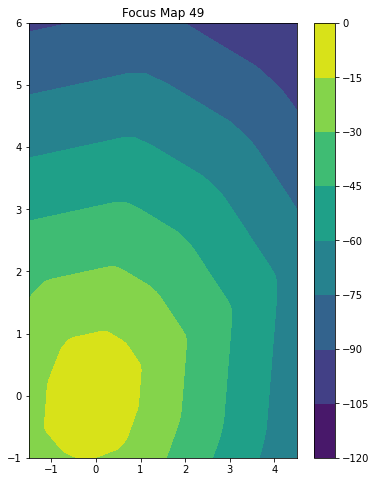

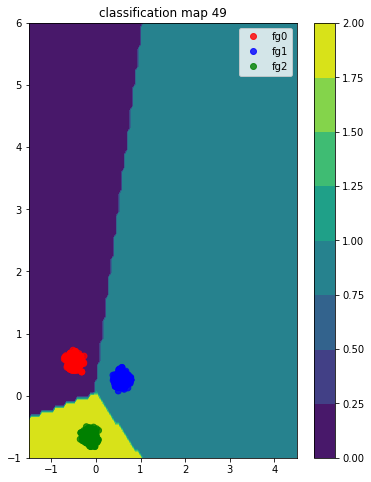

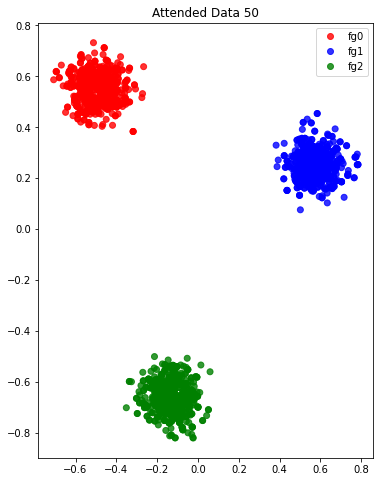

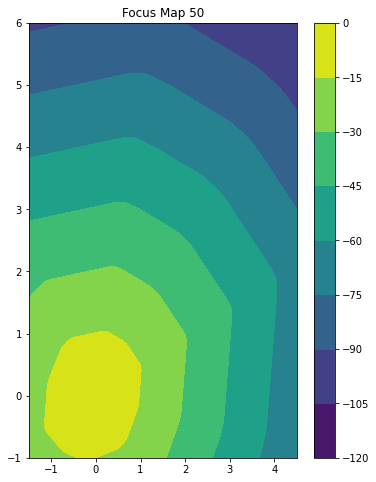

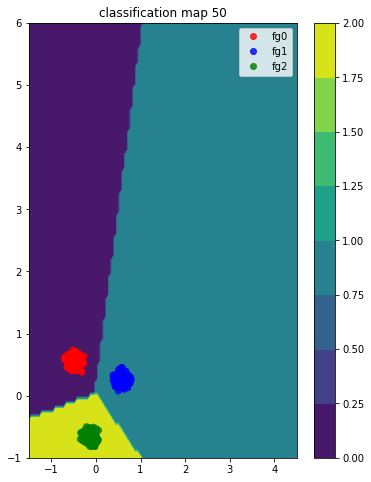

In [111]:
nos_epochs = 50
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    batch = inputs.size(0)
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 20
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    if epoch % 1 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.001):
      break;
  

  if epoch % 1 ==0:
    plot_attended_data(train_loader,focus_net,classify,epoch+1)
  if epoch % 1 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    # print("="*20)
    # print("Train FTPT : ", col4)
    # print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        batch = inputs.size(0)
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # print("Test FTPT : ", col10)
    # print("Test FFPT : ", col11)
    # print("="*20)
    
print('Finished Training')

In [112]:
torch.save(focus_net.state_dict(),path+"_focus.pt")
torch.save(classify.state_dict(),path+"_classify.pt")

In [113]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [114]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [115]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [116]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                      0                    1316
1        1             0  ...                      0                    1327
2        2             0  ...                     21                    1289
3        3             0  ...                     19                    1308
4        4             0  ...                    219                    1101
5        5             0  ...                    256                    1045
6        6             0  ...                    810                     507
7        7             0  ...                    408                     896
8        8             0  ...                   1113                     214
9        9             0  ...                    784                     518
10      10             0  ...                   1268                      24
11      11             0  ...                   1075                     198
12      12             0  ...                   1287                       5
13      13             0  ...                   1139                     143
14      14             0  ...                   1299                       0
15      15             0  ...                   1302                       2
16      16             0  ...                   1295                       8
17      17             0  ...                   1266                       0
18      18             0  ...                   1278                       2
19      19             0  ...                   1267                       1
20      20             0  ...                   1272                       0
21      21             0  ...                   1240                       1
22      22             0  ...                   1204                       0
23      23             0  ...                   1100                       0
24      24           133  ...                    686                       0
25      25          1982  ...                      0                       0
26      26          2000  ...                      0                       0
27      27          2000  ...                      0                       0
28      28          2000  ...                      0                       0
29      29          2000  ...                      0                       0
30      30          2000  ...                      0                       0
31      31          2000  ...                      0                       0
32      32          2000  ...                      0                       0
33      33          2000  ...                      0                       0
34      34          2000  ...                      0                       0
35      35          2000  ...                      0                       0
36      36          2000  ...                      0                       0
37      37          2000  ...                      0                       0
38      38          2000  ...                      0                       0
39      39          2000  ...                      0                       0
40      40          2000  ...                      0                       0
41      41          2000  ...                      0                       0
42      42          2000  ...                      0                       0
43      43          2000  ...                      0                       0
44      44          2000  ...                      0                       0
45      45          2000  ...                      0                       0
46      46          2000  ...                      0                       0
47      47          2000  ...                      0                       0
48      48          2000  ...                      0                       0
49      49          2000  ...                      0                       0
50      50          2000  ...                      0                       0


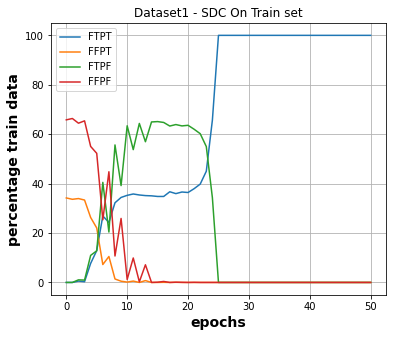

In [117]:
num  = 20
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/num, label ="FTPT")
plt.plot(col1,np.array(col5)/num, label ="FFPT")
plt.plot(col1,np.array(col6)/num, label ="FTPF")
plt.plot(col1,np.array(col7)/num, label ="FFPF")
plt.title("Dataset1 - SDC On Train set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"_train.png", bbox_inches="tight")
plt.savefig(path+"_train.pdf", bbox_inches="tight")
plt.savefig(path+"_train.png", bbox_inches="tight")
plt.savefig(path+"_train.pdf", bbox_inches="tight")
plt.show()

In [118]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                      0                     644
1        1             0  ...                      0                     648
2        2             0  ...                      0                     674
3        3             0  ...                      0                     637
4        4             0  ...                    184                     484
5        5             0  ...                    460                     217
6        6             0  ...                     72                     561
7        7             0  ...                    403                     257
8        8             0  ...                    632                      36
9        9             0  ...                    430                     200
10      10             0  ...                    655                       0
11      11             0  ...                    614                      32
12      12             0  ...                    678                       0
13      13             0  ...                    622                      12
14      14             0  ...                    658                       0
15      15             0  ...                    620                       3
16      16             0  ...                    641                       0
17      17             0  ...                    653                       0
18      18             0  ...                    667                       0
19      19             0  ...                    640                       0
20      20             0  ...                    608                       0
21      21             0  ...                    616                       0
22      22             0  ...                    599                       0
23      23             0  ...                    527                       0
24      24           833  ...                      0                       0
25      25          1000  ...                      0                       0
26      26          1000  ...                      0                       0
27      27          1000  ...                      0                       0
28      28          1000  ...                      0                       0
29      29          1000  ...                      0                       0
30      30          1000  ...                      0                       0
31      31          1000  ...                      0                       0
32      32          1000  ...                      0                       0
33      33          1000  ...                      0                       0
34      34          1000  ...                      0                       0
35      35          1000  ...                      0                       0
36      36          1000  ...                      0                       0
37      37          1000  ...                      0                       0
38      38          1000  ...                      0                       0
39      39          1000  ...                      0                       0
40      40          1000  ...                      0                       0
41      41          1000  ...                      0                       0
42      42          1000  ...                      0                       0
43      43          1000  ...                      0                       0
44      44          1000  ...                      0                       0
45      45          1000  ...                      0                       0
46      46          1000  ...                      0                       0
47      47          1000  ...                      0                       0
48      48          1000  ...                      0                       0
49      49          1000  ...                      0                       0
50      50          1000  ...                      0                       0


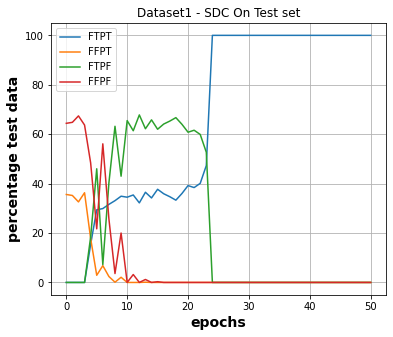

In [119]:
num = 10
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/num, label ="FTPT")
plt.plot(col1,np.array(col11)/num, label ="FFPT")
plt.plot(col1,np.array(col12)/num, label ="FTPF")
plt.plot(col1,np.array(col13)/num, label ="FFPF")
plt.title("Dataset1 - SDC On Test set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"_test.png", bbox_inches="tight")
plt.savefig(path+"_test.pdf", bbox_inches="tight")
plt.savefig(path+"_test.png", bbox_inches="tight")
plt.savefig(path+"_test.pdf", bbox_inches="tight")
plt.show()

In [120]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the train images: 100.000000 %
total correct 2000
total train set images 2000
focus_true_pred_true 2000 =============> FTPT : 100.000000 %
focus_false_pred_true 0 =============> FFPT : 0.000000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 0 =============> FFPF : 0.000000 %
argmax_more_than_half ==================>  2000
argmax_less_than_half ==================>  0


In [121]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the test images: 100.000000 %
total correct 1000
total train set images 1000
focus_true_pred_true 1000 =============> FTPT : 100.000000 %
focus_false_pred_true 0 =============> FFPT : 0.000000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 0 =============> FFPF : 0.000000 %
argmax_more_than_half ==================>  1000
argmax_less_than_half ==================>  0


In [122]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the train images: 100.000000 %
total correct 2000
total train set images 2000


In [123]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the test images: 100.000000 %
total correct 1000
total train set images 1000


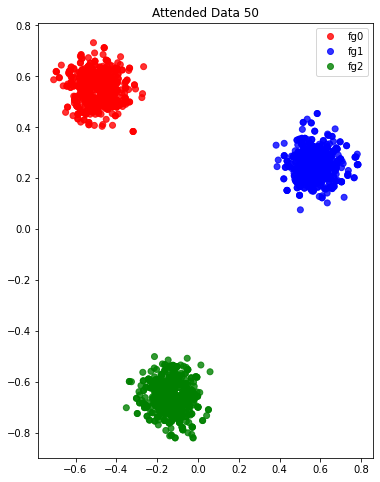

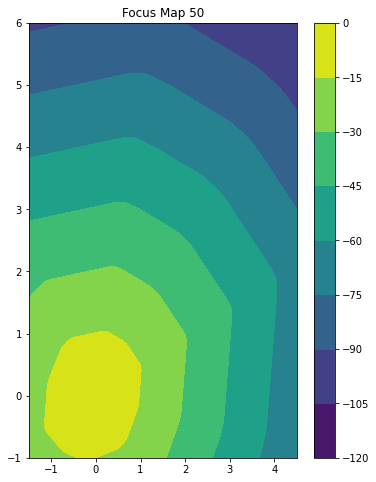

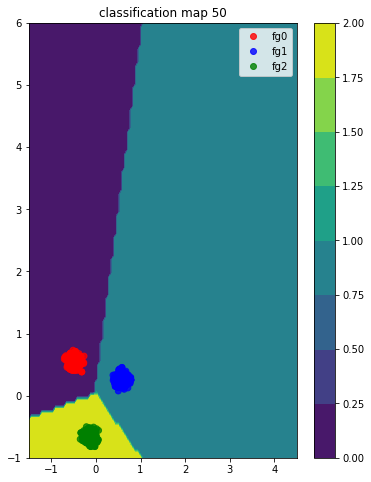

In [124]:
plot_attended_data(train_loader,focus_net,classify,epoch+1)